### Imports

In [61]:
# %pip install torch stable_baselines3 hyperopt gym_mtsim gymnasium seaborn mlforecast pandas==2.0.3 pyarrow xgboost

In [62]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH, FOREX_DATA_PATH_ORIG_FIL, FOREX_DATA_PATH_15MIN
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import time
import torch
import pickle
import importlib
import fx_rl
importlib.reload(fx_rl)
from datetime import datetime, timedelta
import pytz
import concat_latest_data
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

## Enhancing your PPO Trading Bot with a SARIMA Ensemble: Step-by-Step

Here's a detailed approach to integrating a SARIMA model into your existing PPO Reinforcement Learning trading bot using an ensemble methodology:

**1. Data Preparation and Feature Engineering:**

* **Data Gathering:** Ensure you have sufficient historical market data (price, volume, etc.) for both training and validation.
* **Feature Engineering:** 
    * **For PPO:**  Continue using your existing features that have proven effective for your PPO agent.
    * **For SARIMA:**  Extract relevant time series features like lagged prices, moving averages, and volatility indicators.
* **Data Splitting:** Divide your data into training, validation, and testing sets for both models. 

**2. Independent Model Training:**

* **PPO Training:** Train your PPO model as you currently do, optimizing its performance on the training and validation sets.
* **SARIMA Training:** 
    * **Identify Model Order:** Use techniques like ACF/PACF plots and grid search to determine the optimal p, d, and q values for the SARIMA model.
    * **Train SARIMA:** Train the model on the training data and fine-tune its parameters using the validation set.

**3. Ensemble Integration:**

* **Prediction Generation:**
    * **PPO Predictions:** Obtain trading actions (buy, sell, hold) from your trained PPO model for the chosen trading period.
    * **SARIMA Predictions:** Generate price forecasts for the same period using the trained SARIMA model. 
* **Ensemble Strategy:**  There are several ways to combine the models:
    * **Weighted Averaging:** Assign weights to each model's output based on their performance on the validation set.  
        * Example: If PPO performs better, give it a higher weight. The final action is determined by the weighted average of their outputs. 
    * **Voting Mechanism:**  If both models agree on the trade direction (buy or sell), execute the trade. If they disagree, you can either abstain from trading or implement a tie-breaker rule (e.g., based on confidence scores or recent performance).
    * **Meta-Learning:** Train a higher-level model (e.g., a simple logistic regression) to predict the best trading action based on the outputs and confidence scores of both PPO and SARIMA.

**4. Backtesting and Evaluation:**

* **Backtest:**  Rigorously backtest the ensemble model on your testing data to assess its performance under different market conditions. 
* **Metrics:** Evaluate the ensemble strategy using relevant trading metrics such as:
    * Total Profit/Loss
    * Sharpe Ratio
    * Maximum Drawdown
    * Win/Loss Ratio

**5. Deployment and Monitoring:**

* **Deployment:** Once satisfied with the backtesting results, deploy your ensemble model to trade in a live market environment. 
* **Monitoring:** Continuously monitor the performance of the ensemble and individual models. Periodically retrain the models on new data to adapt to changing market dynamics. 

**Important Considerations:**

* **Complexity:** The ensemble approach adds complexity. Ensure you have the computational resources and expertise to manage it effectively.
* **Overfitting:** Be cautious of overfitting during training. Use robust validation techniques and avoid over-reliance on past performance. 
* **Market Dynamics:**  The financial market is highly dynamic. Continuously monitor and adjust your models to maintain their effectiveness. 

**Example Code Snippet (Conceptual):**

```python
# Assuming you have trained PPO and SARIMA models
ppo_action = ppo_model.predict(current_state) 
sarima_forecast = sarima_model.predict(n_periods=1)

# Weighted averaging example:
ensemble_action = 0.7 * ppo_action + 0.3 * sarima_forecast

# Execute trade based on ensemble_action
```

Remember, this is a high-level framework. You'll need to adapt it to your specific implementation, data, and chosen ensemble strategy.  

Your approach of combining time series regression models with reinforcement learning for EURUSD price prediction and trading is interesting. To create an effective ensemble, here are some strategies to consider:

1. Sequential Integration:
   Use the predictions from your LightGBM and Ridge models as additional input features for your reinforcement learning (RL) model. This way, the RL model can learn to interpret and act on the regression predictions alongside other market data.

2. Weighted Decision Making:
   Assign weights to the predictions from your regression models and the action suggested by the RL model. These weights could be static based on historical performance or dynamically adjusted based on recent accuracy.

3. Voting System:
   Implement a voting mechanism where each model (LightGBM, Ridge, and RL) gets a vote on the trading action. The final decision could be based on majority or a more complex voting scheme.

4. Meta-Learning Approach:
   Train another model (e.g., a random forest or neural network) that takes as input the predictions from your regression models and the suggested action from your RL model, and outputs the final trading decision.

5. State Augmentation for RL:
   Expand the state space of your RL model to include the predictions from the regression models. This allows the RL agent to learn how to best utilize these predictions in its decision-making process.

6. Hybrid Reward Function:
   Modify the reward function of your RL model to incorporate the accuracy of the regression models' predictions. This encourages the RL model to learn when to trust or discount the regression predictions.

7. Time-based Ensemble:
   Use different models for different time horizons. For example, use regression models for short-term price predictions and the RL model for deciding on longer-term trading strategies.

8. Confidence-based Switching:
   Implement a mechanism to switch between models based on their confidence levels or recent performance metrics.

Given the nature of your problem, I would recommend starting with the Sequential Integration approach (#1). This method allows your RL model to learn from the regression predictions while still maintaining its ability to make decisions based on a broader set of market conditions and its learned strategy.

To implement this:
1. Generate predictions from your LightGBM and Ridge models.
2. Include these predictions as additional features in the state space of your RL model.
3. Retrain your RL model with this augmented state space.

This approach leverages the strengths of both your regression models (capturing short-term price movements) and your RL model (learning optimal trading strategies over time). The RL model can learn when to trust the regression predictions and when to rely more on other factors.

As you refine your ensemble, you might consider incorporating elements of the other strategies, such as using a weighted decision-making process (#2) or implementing a confidence-based switching mechanism (#8) to further improve performance.

Remember to thoroughly backtest any changes and be mindful of potential overfitting, especially when combining multiple predictive models. It's also crucial to continuously validate the ensemble's performance out-of-sample to ensure its effectiveness in live trading conditions.


## Latest Data

In [63]:
now = datetime.now()
current_time = pd.to_datetime(now) + timedelta(hours=7)
current_time = current_time.replace(tzinfo=pytz.UTC)
# date_15min = fx_rl.bars_back(current_time, 'M15')
# date_5min = fx_rl.bars_back(current_time, 'M5')
date_1hr = fx_rl.bars_back(current_time, 'H1', total_bars=50_000)
date_1hr

Timestamp('2016-09-05 10:00:00+0000', tz='UTC')

In [64]:
# possible other pairs to look into = ['EURUSD', 'AUDCHF', 'NZDCHF', 'GBPNZD', 'USDCAD']

In [65]:
# #.from_pandas(full_data.reset_index())\
# with open(FOREX_DATA_PATH, 'rb') as f:
#     symbols_1hr = pickle.load(f)
# # convert symbols_1hr to a pd.dataframe
# symbols_1hr[1]['EURUSD'].index = pd.to_datetime(symbols_1hr[1]['EURUSD'].index)

# pl_df = ( pl.scan_csv('EURUSD_full_tickstory_data_hourly.csv')
#     .with_columns([
#         # pl.col('Time').str.to_datetime(format='%Y-%m-%d %H:%M:%S+00:00'),
#         pl.col('Open').cast(pl.Float64).alias('Open'),
#         pl.col('High').cast(pl.Float64).alias('High'),
#         pl.col('Low').cast(pl.Float64).alias('Low'),
#         pl.col('Close').cast(pl.Float64).alias('Close'),
#     ])).collect().to_pandas().set_index('Time')

# pl_df.index = pd.to_datetime(pl_df.index)
# symbols_1hr[1]['EURUSD'] = pl_df
# with open(FOREX_DATA_PATH, 'wb') as f:
#     pickle.dump(symbols_1hr, f)

In [66]:
with open(FOREX_DATA_PATH, 'rb') as f:
    symbols_1hr = pickle.load(f)
# convert symbols_1hr to a pd.dataframe
symbols_1hr[1]['EURUSD'].index = pd.to_datetime(symbols_1hr[1]['EURUSD'].index)
full_data = symbols_1hr[1]['EURUSD']
full_data.head()

,Open,High,Low,Close
Time,,,,
2016-08-01 03:00:00+00:00,1.11672,1.11767,1.11660,1.11750
2016-08-01 04:00:00+00:00,1.11750,1.11782,1.11683,1.11719
2016-08-01 05:00:00+00:00,1.11719,1.11753,1.11698,1.11709
2016-08-01 06:00:00+00:00,1.11710,1.11785,1.11662,1.11785
2016-08-01 07:00:00+00:00,1.11784,1.11814,1.11752,1.11794


In [67]:
class MyMtEnv(gym_mtsim.MtEnv):
    # _get_modified_volume = fx_rl.my_get_modified_volume
    _get_prices = fx_rl.my_get_prices

In [68]:
# #.from_pandas(full_data.reset_index())\
# with open(FOREX_DATA_PATH_15MIN, 'rb') as f:
#     symbols_15min = pickle.load(f)
# # convert symbols_1hr to a pd.dataframe
# symbols_15min[1]['EURUSD'].index = pd.to_datetime(symbols_15min[1]['EURUSD'].index)

# pl_df = ( pl.scan_csv('EURUSD_full_tickstory_data_15_min.csv')
#     .with_columns([
#         pl.col('').alias('Time').str.to_datetime(format='%Y-%m-%d %H:%M:%S'),
#         pl.col('').alias('ds').str.to_datetime(format='%Y-%m-%d %H:%M:%S'),
#         ((pl.col('Open').cast(pl.Float64) + pl.col('High').cast(pl.Float64)
#            + pl.col('Low').cast(pl.Float64) + pl.col('Close').cast(pl.Float64)) / 4).round(5).alias('Close')
#     ])
#     .select('Time', 'Close', 'ds')).collect()

# news_data = concat_latest_data.check_for_new_news()
# news_counts = news_data.group_by('datetime').len().sort(by='datetime')

# df_w_news = concat_latest_data.find_seconds_to_next_news(pl_df, news_counts)
# df_ready = df_w_news.drop('ds').to_pandas().set_index('Time')
# # df_ready
# # symbols_15min[1]['EURUSD'] = df_ready
# # with open(FOREX_DATA_PATH_15MIN, 'wb') as f:
# #     pickle.dump(symbols_15min, f)

In [69]:
# with open(FOREX_DATA_PATH_15MIN, 'rb') as f:
#     symbols_15min = pickle.load(f)
# df_15_min = symbols_15min[1]['EURUSD']
# # add a row number column to df_15_min
# df_15_min_index_reset = df_15_min.reset_index().reset_index().rename(columns={'index': 'ds'})

In [70]:
# rwd = pd.read_csv('crossvalidation_df_RWD.csv').drop('ds', axis=1).rename(columns={'cutoff': 'ds', 'RWD': 'Pred'})
# df_15_min_rwd = df_15_min_index_reset.merge(rwd[['ds', 'Pred']], on='ds', how='left')
# df_15_min_rwd['Time'] = pd.to_datetime(df_15_min_rwd['Time'], format='%Y-%m-%d %H:%M:%S+00:00', utc=True)
# df_15_min_rwd_final = df_15_min_rwd.set_index('Time').drop(columns='ds').dropna(subset=['Pred'])\
#     [['Close', 'Pred', 'seconds_since_last_news_event','seconds_to_next_news_event']]
# # symbols_15min[1]['EURUSD'] = df_15_min_rwd_final
# # with open(FOREX_DATA_PATH_15MIN, 'wb') as f:
# #     pickle.dump(symbols_15min, f)

In [71]:
# full_data_w_pred = full_data.merge(df_15_min_rwd_final[['Pred']], left_index=True, right_index=True, how='inner')\
# [['Close', 'Pred', 'seconds_since_last_news_event', 'seconds_to_next_news_event']]
# full_data_w_pred.head()

In [72]:
# full_data_w_pred.to_csv('EURUSD_full_tickstory_data_hourly_w_15min_pred.csv')
# symbols_1hr[1]['EURUSD'] = full_data_w_pred
# with open(FOREX_DATA_PATH, 'wb') as f:
#     pickle.dump(symbols_1hr, f)

In [73]:
# print(concat_latest_data.get_latest_data_fx()) 

In [74]:
with open(FOREX_DATA_PATH, 'rb') as f:
    symbols_1hr = pickle.load(f)
# convert symbols_1hr to a pd.dataframe
symbols_1hr[1]['EURUSD'].index = pd.to_datetime(symbols_1hr[1]['EURUSD'].index)
max_date_1hr = symbols_1hr[1]['EURUSD'].index.max()
max_date_1hr

Timestamp('2024-08-09 23:00:00+0000', tz='UTC')

In [75]:
# slices_5min = fx_rl.slices_finder(symbols_5min[1]['EURUSD'], max_date_5min, testing_needed=True)
# slices_15min = fx_rl.slices_finder(symbols_15min[1]['EURUSD'], max_date_15min, testing_needed=True)
slices_1hr = fx_rl.slices_finder(symbols_1hr[1]['EURUSD'], max_date_1hr, testing_needed=True)

In [76]:
print(slices_1hr[0].min(), '\n',slices_1hr[0].max(), '\n',
slices_1hr[1].min(), '\n',slices_1hr[1].max(),'\n',
slices_1hr[2].min(), '\n',slices_1hr[2].max())

2016-08-01 03:00:00+00:00 
 2024-07-26 23:00:00+00:00 
 2024-07-26 23:00:00+00:00 
 2024-08-02 23:00:00+00:00 
 2024-08-02 23:00:00+00:00 
 2024-08-09 23:00:00+00:00


In [77]:
def check_missing_hourly_data(data):
    """
    Checks for missing values in a pandas Series with hourly datetime index,
    ignoring weekends and US bank holidays.

    Args:
        data: A pandas Series with a datetime index.

    Returns:
        None. Prints a message indicating if there are missing values.
    """
    # Check if the index is datetime-like
    if not pd.api.types.is_datetime64_any_dtype(data):
        raise ValueError("Data index should be a datetime type.")

    holidays = ['12-25', '01-01']

    # Generate expected datetime range
    expected_range = pd.date_range(start=data.min(), end=data.max(), freq='H')
    
    # Filter out weekends and holidays
    expected_range = expected_range[expected_range.dayofweek < 5]  # Monday = 0, Friday = 4
    expected_range = expected_range[~expected_range.strftime('%m-%d').isin(holidays)]

    # Find missing times
    missing_times = expected_range.difference(data)

    # Print results
    if missing_times.empty:
        print("There are no missing values.")
    else:
        return missing_times

# Example usage (assuming slices_1hr is a list of pandas Series):
missing = check_missing_hourly_data(slices_1hr[0])
missing

There are no missing values.


#### To fix missing values

In [78]:

# # find the average variation for the Highs and Lows during for the 5 rows before and 5 rows after the missing time
# imputing_missing_high_1 = symbols_1hr[1]['EURUSD'][(symbols_1hr[1]['EURUSD'].index >= '2019-05-26 19:00:00') & 
#                          (symbols_1hr[1]['EURUSD'].index < '2019-05-27 06:00:00')].copy()
# # column for diff between Open and High and Open and Low
# imputing_missing_high_1.loc[:, 'diff_Open_High'] = imputing_missing_high_1['Open'] - imputing_missing_high_1['High']
# imputing_missing_high_1.loc[:, 'diff_Open_Low'] = imputing_missing_high_1['Open'] - imputing_missing_high_1['Low']
# # column for diff between Close and High and Close and Low
# imputing_missing_high_1.loc[:, 'diff_Close_High'] = imputing_missing_high_1['Close'] - imputing_missing_high_1['High']
# imputing_missing_high_1.loc[:, 'diff_Close_Low'] = imputing_missing_high_1['Close'] - imputing_missing_high_1['Low']
# # find the average of the newly created columns 
# imputing_missing_high_1[['diff_Open_High', 'diff_Open_Low', 'diff_Close_High', 'diff_Close_Low']].mean()
# # 1.11625 - ((0.001588 + 0.001164)/2)
# # # create a new row for the missing time at 2016-09-02 21:00:00
# missing_row = pd.DataFrame([[1.12068, 1.12069, 1.12068, 1.12068]], columns=['Open', 'High', 'Low', 'Close'], index=[pd.Timestamp('2019-05-27 00:00:00')])
# missing_row2 = pd.DataFrame([[1.12068, 1.12067, 1.12068, 1.12068]], columns=['Open', 'High', 'Low', 'Close'], index=[pd.Timestamp('2019-05-27 01:00:00')])
# symbols_1hr[1]['EURUSD'] = pd.concat([symbols_1hr[1]['EURUSD'], missing_row]).sort_index()
# symbols_1hr[1]['EURUSD'] = pd.concat([symbols_1hr[1]['EURUSD'], missing_row2]).sort_index()

# # # drop duplicates in the index
# symbols_1hr[1]['EURUSD'].drop_duplicates(keep='last', inplace=True)

### Create Env

In [79]:
sim_train_1hr = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)
# gym_mtsim.MtEnv, MyMtEnv
env_train_1hr = gym_mtsim.MtEnv(
    original_simulator=sim_train_1hr,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[0],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [80]:
sim_validation_1hr = MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation_1hr = gym_mtsim.MtEnv(# gym_mtsim.MtEnv
    original_simulator=sim_validation_1hr,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[1],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [81]:
sim_testing = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_testing = gym_mtsim.MtEnv( # gym_mtsim.MtEnv
    original_simulator=sim_testing,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[2],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

### Define Functions

In [82]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001
        mean_value = env_orders['Volume'].mean()

        # # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume'] = round((env_orders['Volume'] / mean_value), 2)

        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0

        profit_factor = profit_factor - 1

        return profit_factor, total_reward

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


## Binary Classifier Fx's

In [128]:
def objective_classification(trial, x_train, x_test, y_train, y_test):
    # Define the hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        # 'use_label_encoder': False,  # Important to avoid warnings in XGBoost > 1.3
        'eval_metric': 'mlogloss'  # Metric to use
    }

    # Create the XGBClassifier model with the suggested hyperparameters
    xgb_classifier = XGBClassifier(**param, random_state=42)
    
    # Train the model
    xgb_classifier.fit(x_train, y_train)
    
    # Make predictions on the validation set
    y_pred = xgb_classifier.predict(x_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy
def get_best_classification_model(data_for_classification):
    x, y = data_for_classification.drop(columns=['Profitable']), data_for_classification['Profitable']

    # split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    # Create an Optuna study object and specify the optimization direction
    study = optuna.create_study(direction="maximize")

    # Optimize the study using the objective function
    study.optimize(lambda trial: objective_classification(trial, x_train, x_test, y_train, y_test), n_trials=100, n_jobs=-1)  # Adjust n_trials as needed

    # Output the best trial
    # print(f"Best trial:\n{study.best_trial}")
    print(f"Best accuracy: {study.best_value}")
    # print(f"Best hyperparameters: {study.best_trial.params}")
    # Extract the best hyperparameters
    best_params = study.best_trial.params

    # Train the final model using the best hyperparameters
    best_xgb_classifier = XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

    # Fit the model on the full training data
    best_xgb_classifier.fit(x_train, y_train)

    # Make predictions on the test data
    y_pred_best = best_xgb_classifier.predict(x_test)

    # Evaluate the model
    print("Classification Report for Best Hyperparameters:")
    print(classification_report(y_test, y_pred_best))

    # Confusion Matrix
    print("Confusion Matrix for Best Hyperparameters:")
    print(confusion_matrix(y_test, y_pred_best))

    best_xgb_classifier.fit(x, y)

    return best_xgb_classifier

def aggregate_ohlc(row, data):
    if pd.notnull(row['Profitable']):
        idx = row.name
        if idx >= 5:
            prev_5_rows = data.loc[idx-5:idx, ['Open', 'High', 'Low', 'Close']]

            return prev_5_rows.mean()
        
    return row[['Open', 'High', 'Low', 'Close']]

def binary_classification_orders(orders_df, full_raw_data, min_date, max_date):
    raw_data = full_raw_data.loc[min_date:max_date]
    orders_df.loc[:, 'Profitable'] = (orders_df['Profit'] > 0).astype(int)
    orders_df_sel = orders_df.loc[:, ['Entry Time', 'Profitable']].copy()
    # merge raw_data with orders_df
    data =  pd.merge(raw_data, orders_df_sel, left_index=True, right_on='Entry Time', how='left').drop('Entry Time', axis=1)
    data_index_reset = data.reset_index()
    aggregated_data = data_index_reset.apply(lambda row: aggregate_ohlc(row, data_index_reset), axis=1)
    data_index_reset[['Open', 'High', 'Low', 'Close']] = aggregated_data
    data_ready = data_index_reset.drop('index', axis=1).dropna()
    best_classification_model = get_best_classification_model(data_ready)
    
    return best_classification_model


In [116]:
space = {
    # 'learning_rate': hp.loguniform('learning_rate', -5, -2), # Learning rate
    'learning_rate': hp.uniform('learning_rate', 0, 0.04), # Learning rate
    'gamma': hp.uniform('gamma', 0.925, 0.975), # Discount factor
    # 'ent_coef': hp.loguniform('ent_coef', -5, 0) # Entropy coefficient
    'ent_coef': hp.uniform('ent_coef', 0, 0.05), # Entropy coefficient
    # 'learning_timesteps': hp.choice('learning_timesteps', [25, 50, 100, 250, 500]),
    # 'timeframe': hp.choice('timeframe', ['5min', '15min', '1hr'])
}

In [131]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, lr, gamma_param, entropy, binary_class=False,
                     episodes=100, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    # env_tr.window_size = window_size_param
    print(f'entropy: {entropy}, learning rate: {lr}, gamma: {gamma_param}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    obs_tr, info_tr = env_tr.reset(seed=seed)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))
    # print(env_tr.render()['orders'].columns)
    if binary_class:
        best_classification_model = binary_classification_orders(env_tr.render()['orders'], full_data, slices_1hr[0].min(), slices_1hr[0].max())

    reward_over_validations = []
    orders_over_validations = []
    profit_over_validations = []

    for episode in range(0, episodes):
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False
        iteration = 1
        while not done_val:
            action, _states = model.predict(obs_val)
            if binary_class:
                current_time_step = env_val.simulator.current_time
                classification_x = full_data.loc[(full_data.index <= current_time_step), 
                                                ['Open', 'High', 'Low', 'Close']].reset_index(drop=True).tail(5).mean().to_frame().T
                y_pred = best_classification_model.predict(classification_x)
                if y_pred == 0:
                    action[-1] = 0.01
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val
            iteration += 1
            total_reward += reward_val
            if done_val:
                break
        try:
            orders_made_in_episode = env_val.render()['orders']
            order_len = len(orders_made_in_episode)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode, 0.001)
            
        except Exception as e:
            print(f'There were not any orders produced by the model. Error: {e}')
            order_len = 0
            total_profit = 0

        # model_dict[f'model_{episode}'] = model
        # model.save(f'best_hyperparameters/models_4_26_24/model_{episode}.pkl')

        reward_over_validations.append(total_reward) 
        profit_over_validations.append(total_profit)   
        orders_over_validations.append(order_len)  
        # print(episode)


    # if episode % 1 == 0:
    avg_reward = np.mean(reward_over_validations)
    avg_orders = np.mean(orders_over_validations)
    avg_profit = np.mean(profit_over_validations)
    print(f'Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}, avg Profit: {avg_profit:.3f}')
    # if np.mean(profit_over_validations) > 0:
    #     model.save(f'models_{max_date_1hr.date()}/model_{steps_str}_{max_date_1hr.date()}.pkl')
    return reward_over_validations, orders_over_validations, profit_over_validations#, model_dict
    # return avg_reward, avg_orders, avg_profit

In [129]:
# reward_binary, orders_binary, profit_binary = train_val_model(PPO, 'MultiInputPolicy', env_train_1hr, env_validation_1hr, 2024, '0', 0.0003, 0.99, 0.0, 
#                 binary_class=True, episodes=100, total_learning_timesteps=10_000)
# reward_reg, orders_reg, profit_reg = train_val_model(PPO, 'MultiInputPolicy', env_train_1hr, env_validation_1hr, 2024, '0', 0.0003, 0.99, 0.0, 
#                 episodes=100, total_learning_timesteps=10_000)
# reward_reg, orders_reg, profit_reg = (0.4073362146737329, 45.95, 407.0893357186128)
# reward_binary, orders_binary, profit_binary = (0.617992372502323, 45.95, 606.8669122232047)


In [20]:
import os
# create a folder with the name of the date
os.makedirs(f'models_{max_date_1hr.date()}', exist_ok=True)

## Objective Function

In [136]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
step_key = 0
timesteps_models_dict = {}
def objective(params):
    learning_timesteps = 250 #params['learning_timesteps']
    ent_coef = params['ent_coef']# 0.0 #
    gamma = params['gamma'] # #0.99
    learning_rate = params['learning_rate']#0.0003#
    global step_key

    # timeframe = params['timeframe']
    # if timeframe == '5min':
    #     env_train = env_train_5min
    #     env_validation = env_validation_5min
    # elif timeframe == '15min':
    #     env_train = env_train_15min
    #     env_validation = env_validation_15min
    # elif timeframe == '1hr':
    #     env_train = env_train_1hr
    #     env_validation = env_validation_1hr

    if learning_rate > 0.08:
        print(f'Learning rate too high: {learning_rate}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    if ent_coef > 0.1:
        print(f'Entropy too high: {ent_coef}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

    total_learning_timesteps = learning_timesteps * 1000
    step_key += 1
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    # plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders, profits = train_val_model(PPO, policy, env_train_1hr, env_validation_1hr, seed, step_key, 
                                                    learning_rate, gamma, ent_coef, binary_class=True,
                                                    episodes=100, total_learning_timesteps=total_learning_timesteps)
    except Exception as e:
        if 'Tensor of shape' in str(e):
            print(f'''there was an error with the tensor with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        else:
            print(f'''there was an error {e} with those parameters: timesteps: {learning_timesteps}, \n
                ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(profits, 'Profits')
    print_stats(orders, 'Orders')
    # label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    # plot_data[plot_key] = rewards
    # plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)
    params['rewards'] = np.mean(rewards)       

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [133]:
# sim_train_1hr = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )
# # gym_mtsim.MtEnv
# env_train_1hr = MyMtEnv(
#     original_simulator=sim_train_1hr,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_1hr[0],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )
# sim_validation_1hr = MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

# env_validation_1hr = MyMtEnv(# gym_mtsim.MtEnv
#     original_simulator=sim_validation_1hr,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_1hr[1],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )
# # # check if it is working:
# parameters = {
#     # 'window_size': 10,
#     # 'learning_timesteps': 25,
#     'ent_coef': 0.008841807731982131,
#     'gamma': 0.9484679718228304,
#     'learning_rate': 0.021173768344759137
# }
# objective(parameters)

In [18]:
# orig_data = pd.read_csv('EURUSD_full_tickstory_data_hourly.csv')
# orig_data['Time'] = pd.to_datetime(orig_data['Time'])
# orig_data.set_index('Time', inplace=True)
# orig_data_fil = orig_data[orig_data.index >= '2018-03-08 11:00:00+00:00'].copy()
# orig_data_fil.to_csv('EURUSD_full_tickstory_data_hourly_filtered.csv')
# # with open(FOREX_DATA_PATH_ORIG_FIL, 'rb') as f:
# #     symbols_orig_fil = pickle.load(f)
# # symbols_orig_fil[1]['EURUSD'] = orig_data_fil
# # with open(FOREX_DATA_PATH_ORIG_FIL, 'wb') as f:
# #     pickle.dump(symbols_orig_fil, f)

In [23]:

# PPO('MultiInputPolicy', env_train, verbose=0, ent_coef=parameters['ent_coef']).learn(total_timesteps=25_000) #, learning_rate=parameters['learning_rate'], gamma=parameters['gamma'], ent_coef=parameters['ent_coef']

In [137]:
#### adding in gamma test ####
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=250, # Number of evaluations of the objective function
            trials=trials,
            trials_save_file=f'gym_mtsim_forked/examples/hyperopt/trials_{max_date_1hr.date()}_search_next_week.pkl')

print("Best parameters:", best)

--------------------------------------------------------------------------------
entropy: 0.029708268390928917, learning rate: 0.01957505828547994, gamma: 0.972825688606014
Best accuracy: 0.6666666666666666                      
Classification Report for Best Hyperparameters:        
              precision    recall  f1-score   support  

         0.0       0.67      1.00      0.80         4
         1.0       0.00      0.00      0.00         2

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6

Confusion Matrix for Best Hyperparameters:             
[[4 0]                                                 
 [2 0]]
  0%|          | 0/250 [08:33<?, ?trial/s, best loss=?]

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.504, # of orders: 52.100, avg Profit: 689.543
Min. Profits          :   -634.959                     
Avg. Profits          :    689.543                     
Max. Profits          :   2239.813                     
Min. Orders          :     38.000                      
Avg. Orders          :     52.100                      
Max. Orders          :     66.000                      
--------------------------------------------------------------------------------     
entropy: 0.03708582795961942, learning rate: 0.016358095636513623, gamma: 0.9673919688841124
Best accuracy: 0.6666666666666666                                                    
Classification Report for Best Hyperparameters:                                      
              precision    recall  f1-score   support                                

         0.0       0.67      1.00      0.80         4
         1.0       0.00      0.00      0.00         2

    accuracy                           0.67         6
  

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.511, # of orders: 52.100, avg Profit: 696.228                         
Min. Profits          :   -616.298                                                   
Avg. Profits          :    696.228                                                   
Max. Profits          :   2212.598                                                   
Min. Orders          :     38.000                                                    
Avg. Orders          :     52.100                                                    
Max. Orders          :     66.000                                                    
--------------------------------------------------------------------------------     
entropy: 0.004446817355583649, learning rate: 0.01834219660514886, gamma: 0.9423695689162966
Best accuracy: 0.62                                                                  
Classification Report for Best Hyperparameters:                                      
              precision    recall  f1-score   s

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.441, # of orders: 61.970, avg Profit: 694.919                         
Min. Profits          :   -542.534                                                   
Avg. Profits          :    694.919                                                   
Max. Profits          :   1978.253                                                   
Min. Orders          :     49.000                                                    
Avg. Orders          :     61.970                                                    
Max. Orders          :     74.000                                                    
--------------------------------------------------------------------------------     
entropy: 0.004030010460393557, learning rate: 0.0217674542522263, gamma: 0.936759314529873
Best accuracy: 0.7142857142857143                                                    
Classification Report for Best Hyperparameters:                                      
              precision    recall  f1-score   sup

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.488, # of orders: 52.980, avg Profit: 684.595                         
Min. Profits          :   -549.022                                                   
Avg. Profits          :    684.595                                                   
Max. Profits          :   2103.155                                                   
Min. Orders          :     40.000                                                    
Avg. Orders          :     52.980                                                    
Max. Orders          :     66.000                                                    
--------------------------------------------------------------------------------     
entropy: 0.019616893400192698, learning rate: 0.028784858767449274, gamma: 0.9479961105815684
Best accuracy: 0.8                                                                   
Classification Report for Best Hyperparameters:                                      
              precision    recall  f1-score   

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.515, # of orders: 52.080, avg Profit: 692.174                         
Min. Profits          :   -772.567                                                   
Avg. Profits          :    692.174                                                   
Max. Profits          :   2123.041                                                   
Min. Orders          :     38.000                                                    
Avg. Orders          :     52.080                                                    
Max. Orders          :     65.000                                                    
--------------------------------------------------------------------------------     
entropy: 0.01041115025445495, learning rate: 0.0044887288509278854, gamma: 0.9599418643565025
Best accuracy: 0.7727272727272727                                                    
Classification Report for Best Hyperparameters:                                      
              precision    recall  f1-score   

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



There were not any orders produced by the model. Error: 'Volume'                     
Avg. Reward: 2.090, # of orders: 4.370, avg Profit: 43.060                           
Min. Profits          :   -340.879                                                   
Avg. Profits          :     43.060                                                   
Max. Profits          :   1880.996                                                   
Min. Orders          :      0.000                                                    
Avg. Orders          :      4.370                                                    
Max. Orders          :      9.000                                                    
--------------------------------------------------------------------------------     
entropy: 0.030141603356217725, learning rate: 0.004398171695823243, gamma: 0.9255905206636713
Best accuracy: 0.782608695652174                                                     
Classification Report for Best Hyperparameters

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 2.704, # of orders: 49.630, avg Profit: -520.809                          
Min. Profits          :  -2500.435                                                     
Avg. Profits          :   -520.809                                                     
Max. Profits          :   1207.499                                                     
Min. Orders          :     36.000                                                      
Avg. Orders          :     49.630                                                      
Max. Orders          :     64.000                                                      
--------------------------------------------------------------------------------       
entropy: 0.022847853700051463, learning rate: 0.02152856999388967, gamma: 0.9336344009475502
Best accuracy: 0.6666666666666666                                                      
Classification Report for Best Hyperparameters:                                        
              precision    

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.509, # of orders: 52.100, avg Profit: 694.901                           
Min. Profits          :   -620.692                                                     
Avg. Profits          :    694.901                                                     
Max. Profits          :   2188.796                                                     
Min. Orders          :     38.000                                                      
Avg. Orders          :     52.100                                                      
Max. Orders          :     66.000                                                      
--------------------------------------------------------------------------------       
entropy: 0.008094709842963161, learning rate: 0.035682760141645196, gamma: 0.9470771497903843
Best accuracy: 0.6428571428571429                                                      
Classification Report for Best Hyperparameters:                                        
              precision   

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.262, # of orders: 44.060, avg Profit: 260.884                           
Min. Profits          :   -695.215                                                     
Avg. Profits          :    260.884                                                     
Max. Profits          :   1469.384                                                     
Min. Orders          :     34.000                                                      
Avg. Orders          :     44.060                                                      
Max. Orders          :     57.000                                                      
--------------------------------------------------------------------------------       
entropy: 0.02462610910972613, learning rate: 0.009790617957155964, gamma: 0.9471267366826334
Best accuracy: 0.6666666666666666                                                      
Classification Report for Best Hyperparameters:                                        
              precision    

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 10.851, # of orders: 53.340, avg Profit: -425.934                         
Min. Profits          :  -2615.238                                                     
Avg. Profits          :   -425.934                                                     
Max. Profits          :   1908.353                                                     
Min. Orders          :     42.000                                                      
Avg. Orders          :     53.340                                                      
Max. Orders          :     67.000                                                      
--------------------------------------------------------------------------------        
entropy: 0.04535507032449823, learning rate: 0.0179299471947074, gamma: 0.9532647248176638
Best accuracy: 0.6666666666666666                                                       
Classification Report for Best Hyperparameters:                                         
              precision   

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:40:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.511, # of orders: 52.100, avg Profit: 695.892                            
Min. Profits          :   -611.149                                                      
Avg. Profits          :    695.892                                                      
Max. Profits          :   2295.262                                                      
Min. Orders          :     38.000                                                       
Avg. Orders          :     52.100                                                       
Max. Orders          :     66.000                                                       
--------------------------------------------------------------------------------        
entropy: 0.048582404099135175, learning rate: 0.03784342470365675, gamma: 0.9691636182075767
there was an error with the tensor with those parameters: timesteps: 250,               

              ent_coef: 0.048582404099135175, gamma: 0.9691636182075767, learning_rate: 0.037843424703656

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.506, # of orders: 52.100, avg Profit: 691.888                            
Min. Profits          :   -653.102                                                      
Avg. Profits          :    691.888                                                      
Max. Profits          :   2197.734                                                      
Min. Orders          :     38.000                                                       
Avg. Orders          :     52.100                                                       
Max. Orders          :     66.000                                                       
--------------------------------------------------------------------------------        
entropy: 0.01718728927703329, learning rate: 0.015405691175091558, gamma: 0.9682404598839914
Best accuracy: 0.8888888888888888                                                       
Classification Report for Best Hyperparameters:                                         
              pre

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:59:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.523, # of orders: 48.220, avg Profit: 660.295                            
Min. Profits          :   -710.814                                                      
Avg. Profits          :    660.295                                                      
Max. Profits          :   2015.306                                                      
Min. Orders          :     36.000                                                       
Avg. Orders          :     48.220                                                       
Max. Orders          :     61.000                                                       
--------------------------------------------------------------------------------        
entropy: 0.01568257320957474, learning rate: 0.03669764476639805, gamma: 0.9725524478100691
Best accuracy: 0.375                                                                    
Classification Report for Best Hyperparameters:                                         
              prec

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.738, # of orders: 38.520, avg Profit: 700.838                            
Min. Profits          :   -663.114                                                      
Avg. Profits          :    700.838                                                      
Max. Profits          :   2240.511                                                      
Min. Orders          :     29.000                                                       
Avg. Orders          :     38.520                                                       
Max. Orders          :     50.000                                                       
--------------------------------------------------------------------------------        
entropy: 0.014568294449170266, learning rate: 0.03568574117856123, gamma: 0.9744116451118081
Best accuracy: 0.7272727272727273                                                       
Classification Report for Best Hyperparameters:                                         
              pre

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:17:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:17:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.590, # of orders: 48.100, avg Profit: 740.700                            
Min. Profits          :   -703.363                                                      
Avg. Profits          :    740.700                                                      
Max. Profits          :   2146.286                                                      
Min. Orders          :     34.000                                                       
Avg. Orders          :     48.100                                                       
Max. Orders          :     61.000                                                       
--------------------------------------------------------------------------------        
entropy: 0.002162822476147791, learning rate: 0.023593062900656832, gamma: 0.959723263101774
Best accuracy: 0.5647058823529412                                                      
Classification Report for Best Hyperparameters:                                        
              preci

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.437, # of orders: 53.270, avg Profit: 604.695                           
Min. Profits          :   -625.758                                                     
Avg. Profits          :    604.695                                                     
Max. Profits          :   2110.413                                                     
Min. Orders          :     39.000                                                      
Avg. Orders          :     53.270                                                      
Max. Orders          :     67.000                                                      
--------------------------------------------------------------------------------       
entropy: 0.0005315764543048663, learning rate: 0.013949201815972812, gamma: 0.9254443059442452
Best accuracy: 0.65625                                                                 
Classification Report for Best Hyperparameters:                                        
              precision  

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 1.616, # of orders: 33.080, avg Profit: 1769.676                          
Min. Profits          :   1206.967                                                     
Avg. Profits          :   1769.676                                                     
Max. Profits          :   2260.225                                                     
Min. Orders          :     24.000                                                      
Avg. Orders          :     33.080                                                      
Max. Orders          :     45.000                                                      
--------------------------------------------------------------------------------         
entropy: 0.03929315750625242, learning rate: 0.03973607539490768, gamma: 0.9737181498167053
there was an error with the tensor with those parameters: timesteps: 250,                

              ent_coef: 0.03929315750625242, gamma: 0.9737181498167053, learning_rate: 0.03973607539490768
----

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.505, # of orders: 52.200, avg Profit: 690.842                             
Min. Profits          :   -643.570                                                       
Avg. Profits          :    690.842                                                       
Max. Profits          :   2230.016                                                       
Min. Orders          :     38.000                                                        
Avg. Orders          :     52.200                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.011943955182206341, learning rate: 0.01140972397748655, gamma: 0.9294167517171967
Best accuracy: 0.5357142857142857                                                        
Classification Report for Best Hyperparameters:                                          
       

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:56:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:56:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.107, # of orders: 40.170, avg Profit: 118.274                             
Min. Profits          :   -909.622                                                       
Avg. Profits          :    118.274                                                       
Max. Profits          :   2342.861                                                       
Min. Orders          :     25.000                                                        
Avg. Orders          :     40.170                                                        
Max. Orders          :     56.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.00045763034444646684, learning rate: 1.6380430438233534e-05, gamma: 0.9617184401296346
Best accuracy: 0.5647668393782384                                                        
Classification Report for Best Hyperparameters:                                          
  

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:07:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.899, # of orders: 39.470, avg Profit: 915.882                             
Min. Profits          :   -691.613                                                       
Avg. Profits          :    915.882                                                       
Max. Profits          :   2430.535                                                       
Min. Orders          :     31.000                                                        
Avg. Orders          :     39.470                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.00035374276764254197, learning rate: 0.011178141411891027, gamma: 0.9608106801217479
Best accuracy: 0.594017094017094                                                         
Classification Report for Best Hyperparameters:                                          
    

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.434, # of orders: 64.040, avg Profit: 704.729                             
Min. Profits          :   -656.297                                                       
Avg. Profits          :    704.729                                                       
Max. Profits          :   2231.553                                                       
Min. Orders          :     52.000                                                        
Avg. Orders          :     64.040                                                        
Max. Orders          :     76.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.0075625927508672745, learning rate: 0.001958045218166955, gamma: 0.9647775438014965
Best accuracy: 0.0                                                                       
Classification Report for Best Hyperparameters:                                          
     

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:40:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:52:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:52:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 1.239, # of orders: 31.120, avg Profit: 1005.525                            
Min. Profits          :   -579.610                                                       
Avg. Profits          :   1005.525                                                       
Max. Profits          :   2322.460                                                       
Min. Orders          :     24.000                                                        
Avg. Orders          :     31.120                                                        
Max. Orders          :     42.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.0071032546317772415, learning rate: 0.007563166957199477, gamma: 0.9397325287718277
Best accuracy: 0.7575757575757576                                                        
Classification Report for Best Hyperparameters:                                          
     

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: -0.116, # of orders: 47.870, avg Profit: -220.983                           
Min. Profits          :  -1271.613                                                       
Avg. Profits          :   -220.983                                                       
Max. Profits          :   1023.280                                                       
Min. Orders          :     36.000                                                        
Avg. Orders          :     47.870                                                        
Max. Orders          :     59.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.012623742544393572, learning rate: 0.013095006755741042, gamma: 0.9570108282161818
Best accuracy: 0.5333333333333333                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.454, # of orders: 43.830, avg Profit: 487.691                             
Min. Profits          :   -670.942                                                       
Avg. Profits          :    487.691                                                       
Max. Profits          :   2117.327                                                       
Min. Orders          :     33.000                                                        
Avg. Orders          :     43.830                                                        
Max. Orders          :     57.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.02176961207427182, learning rate: 0.0016490102153110062, gamma: 0.9428566501566573
Best accuracy: 0.6956521739130435                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:22:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
Avg. Reward: 11.984, # of orders: 3.610, avg Profit: 98.222                              
Min. Profits          :   -287.661                                                       
Avg. Profits          :     98.222                                                       
Max. Profits          :   1737.690                                                       
Min. Orders          :      0.000                                                        
Avg. Orders          :      3.610                                                        
Max. Orders          :      9.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.018610706969330877, learning rate: 0.03291994496311569, gamma: 0.9263932861389097
Best ac

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.058, # of orders: 38.650, avg Profit: 63.392                              
Min. Profits          :   -879.550                                                       
Avg. Profits          :     63.392                                                       
Max. Profits          :   1888.686                                                       
Min. Orders          :     13.000                                                        
Avg. Orders          :     38.650                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.005160893064978153, learning rate: 0.014306723229868758, gamma: 0.9422269245506799
Best accuracy: 0.6666666666666666                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:42:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.511, # of orders: 51.750, avg Profit: 699.030                             
Min. Profits          :   -658.342                                                       
Avg. Profits          :    699.030                                                       
Max. Profits          :   2117.207                                                       
Min. Orders          :     37.000                                                        
Avg. Orders          :     51.750                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.03345704347397477, learning rate: 0.01935322616204125, gamma: 0.9640425905490032
Best accuracy: 0.6666666666666666                                                        
Classification Report for Best Hyperparameters:                                          
        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:04:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.043, # of orders: 36.880, avg Profit: 57.247                              
Min. Profits          :   -839.382                                                       
Avg. Profits          :     57.247                                                       
Max. Profits          :   1485.175                                                       
Min. Orders          :     16.000                                                        
Avg. Orders          :     36.880                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.009397773163506588, learning rate: 0.0003655024827958378, gamma: 0.9359355058317922
Best accuracy: 0.6753246753246753                                                        
Classification Report for Best Hyperparameters:                                          
     

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:18:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:18:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 1.206, # of orders: 14.330, avg Profit: 131.581                             
Min. Profits          :   -917.863                                                       
Avg. Profits          :    131.581                                                       
Max. Profits          :   3443.445                                                       
Min. Orders          :      4.000                                                        
Avg. Orders          :     14.330                                                        
Max. Orders          :     23.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.004576170001669405, learning rate: 0.03076672006240945, gamma: 0.9566906368081327
Best accuracy: 0.5714285714285714                                                        
Classification Report for Best Hyperparameters:                                          
       

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.508, # of orders: 51.920, avg Profit: 696.037                             
Min. Profits          :   -625.011                                                       
Avg. Profits          :    696.037                                                       
Max. Profits          :   2212.261                                                       
Min. Orders          :     38.000                                                        
Avg. Orders          :     51.920                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.013925514907097968, learning rate: 0.025495248671919598, gamma: 0.9445964754011946
Best accuracy: 0.7647058823529411                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 2.696, # of orders: 51.660, avg Profit: -501.471                            
Min. Profits          :  -2421.976                                                       
Avg. Profits          :   -501.471                                                       
Max. Profits          :   1471.968                                                       
Min. Orders          :     38.000                                                        
Avg. Orders          :     51.660                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.03809400008838632, learning rate: 0.017024690603781423, gamma: 0.9516274926733591
Best accuracy: 0.6666666666666666                                                        
Classification Report for Best Hyperparameters:                                          
       

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:48:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.511, # of orders: 52.100, avg Profit: 695.409                             
Min. Profits          :   -611.752                                                       
Avg. Profits          :    695.409                                                       
Max. Profits          :   2215.144                                                       
Min. Orders          :     38.000                                                        
Avg. Orders          :     52.100                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.020581430613029084, learning rate: 0.003836806343794217, gamma: 0.9706802185587866
Best accuracy: 0.71875                                                                   
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:58:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:58:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.260, # of orders: 38.270, avg Profit: 256.546                             
Min. Profits          :  -1050.473                                                       
Avg. Profits          :    256.546                                                       
Max. Profits          :   2429.703                                                       
Min. Orders          :     23.000                                                        
Avg. Orders          :     38.270                                                        
Max. Orders          :     51.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.0034225051208921133, learning rate: 0.021403457836898742, gamma: 0.9390122803346583
Best accuracy: 0.7419354838709677                                                        
Classification Report for Best Hyperparameters:                                          
     

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: -0.280, # of orders: 40.900, avg Profit: -385.027                           
Min. Profits          :  -1071.217                                                       
Avg. Profits          :   -385.027                                                       
Max. Profits          :    422.196                                                       
Min. Orders          :     29.000                                                        
Avg. Orders          :     40.900                                                        
Max. Orders          :     54.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.042000984286694465, learning rate: 0.010416139953657134, gamma: 0.9647635736380856
Best accuracy: 0.5714285714285714                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.514, # of orders: 51.810, avg Profit: 695.966                             
Min. Profits          :   -745.160                                                       
Avg. Profits          :    695.966                                                       
Max. Profits          :   2152.123                                                       
Min. Orders          :     37.000                                                        
Avg. Orders          :     51.810                                                        
Max. Orders          :     65.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.025687113246062394, learning rate: 0.013320918338082105, gamma: 0.9572710724683733
Best accuracy: 0.7142857142857143                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.536, # of orders: 49.310, avg Profit: 688.789                             
Min. Profits          :   -814.754                                                       
Avg. Profits          :    688.789                                                       
Max. Profits          :   2149.125                                                       
Min. Orders          :     37.000                                                        
Avg. Orders          :     49.310                                                        
Max. Orders          :     62.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.010709171261888983, learning rate: 0.008609773314621223, gamma: 0.9494511212238006
Best accuracy: 0.6271186440677966                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:40:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.401, # of orders: 83.080, avg Profit: 881.931                             
Min. Profits          :   -851.406                                                       
Avg. Profits          :    881.931                                                       
Max. Profits          :   1834.748                                                       
Min. Orders          :     71.000                                                        
Avg. Orders          :     83.080                                                        
Max. Orders          :     96.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.006249039314413847, learning rate: 0.0032596051461657696, gamma: 0.9335203642695633
Best accuracy: 0.5798319327731093                                                        
Classification Report for Best Hyperparameters:                                          
     

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.693, # of orders: 23.190, avg Profit: 54.090                              
Min. Profits          :  -1149.144                                                       
Avg. Profits          :     54.090                                                       
Max. Profits          :   3090.482                                                       
Min. Orders          :     13.000                                                        
Avg. Orders          :     23.190                                                        
Max. Orders          :     35.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.03425070276605178, learning rate: 0.0057725640277169745, gamma: 0.9457034245361144
Best accuracy: 0.6666666666666666                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.489, # of orders: 52.920, avg Profit: 679.054                             
Min. Profits          :   -597.648                                                       
Avg. Profits          :    679.054                                                       
Max. Profits          :   2107.211                                                       
Min. Orders          :     40.000                                                        
Avg. Orders          :     52.920                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.026403444562455025, learning rate: 0.01578921798670616, gamma: 0.9272572043426044
Best accuracy: 1.0                                                                       
Classification Report for Best Hyperparameters:                                          
       

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:01:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:01:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.517, # of orders: 51.810, avg Profit: 700.415                             
Min. Profits          :   -795.632                                                       
Avg. Profits          :    700.415                                                       
Max. Profits          :   2110.137                                                       
Min. Orders          :     37.000                                                        
Avg. Orders          :     51.810                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.017653787120521097, learning rate: 0.026969618550937578, gamma: 0.9539777695450506
Best accuracy: 0.6666666666666666                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:08:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:08:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.070, # of orders: 39.000, avg Profit: 79.621                              
Min. Profits          :   -885.502                                                       
Avg. Profits          :     79.621                                                       
Max. Profits          :   1996.639                                                       
Min. Orders          :     12.000                                                        
Avg. Orders          :     39.000                                                        
Max. Orders          :     54.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.008982101315564641, learning rate: 0.03079325867848972, gamma: 0.9661205204718606
Best accuracy: 0.5531914893617021                                                        
Classification Report for Best Hyperparameters:                                          
       

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:16:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:16:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: -0.109, # of orders: 56.000, avg Profit: -199.202                           
Min. Profits          :   -959.070                                                       
Avg. Profits          :   -199.202                                                       
Max. Profits          :    860.205                                                       
Min. Orders          :     40.000                                                        
Avg. Orders          :     56.000                                                        
Max. Orders          :     71.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.003444704598516849, learning rate: 0.022546940683288202, gamma: 0.9510610396824902
Best accuracy: 0.5                                                                       
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:23:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:23:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 1.390, # of orders: 36.540, avg Profit: 1500.424                            
Min. Profits          :   -241.118                                                       
Avg. Profits          :   1500.424                                                       
Max. Profits          :   2390.560                                                       
Min. Orders          :     26.000                                                        
Avg. Orders          :     36.540                                                        
Max. Orders          :     47.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.0022310802684007962, learning rate: 0.022689982203019852, gamma: 0.936902219267883
Best accuracy: 0.64                                                                      
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.258, # of orders: 54.140, avg Profit: 347.514                             
Min. Profits          :   -776.446                                                       
Avg. Profits          :    347.514                                                       
Max. Profits          :   1708.393                                                       
Min. Orders          :     39.000                                                        
Avg. Orders          :     54.140                                                        
Max. Orders          :     68.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.015960082006747256, learning rate: 0.01830627004240278, gamma: 0.9494826302862062
Best accuracy: 0.6119402985074627                                                        
Classification Report for Best Hyperparameters:                                          
       

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 2.599, # of orders: 66.010, avg Profit: -666.328                            
Min. Profits          :  -2801.908                                                       
Avg. Profits          :   -666.328                                                       
Max. Profits          :   1457.609                                                       
Min. Orders          :     53.000                                                        
Avg. Orders          :     66.010                                                        
Max. Orders          :     78.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.00029528873986801017, learning rate: 0.02477934097432175, gamma: 0.9469330465589778
Best accuracy: 0.72                                                                      
Classification Report for Best Hyperparameters:                                          
     

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 2.689, # of orders: 17.070, avg Profit: 1846.618                            
Min. Profits          :    234.821                                                       
Avg. Profits          :   1846.618                                                       
Max. Profits          :   2587.609                                                       
Min. Orders          :      9.000                                                        
Avg. Orders          :     17.070                                                        
Max. Orders          :     32.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.043188886151179225, learning rate: 0.03387442828222165, gamma: 0.9318487635396844
there was an error with the tensor with those parameters: timesteps: 250,                

              ent_coef: 0.043188886151179225, gamma: 0.9318487635396844, learning_rate: 0.033874

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 1.662, # of orders: 32.150, avg Profit: 1739.235                            
Min. Profits          :    194.153                                                       
Avg. Profits          :   1739.235                                                       
Max. Profits          :   2290.763                                                       
Min. Orders          :     22.000                                                        
Avg. Orders          :     32.150                                                        
Max. Orders          :     43.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.02429168904337148, learning rate: 0.02061343739992122, gamma: 0.9350560587698428
Best accuracy: 0.8571428571428571                                                        
Classification Report for Best Hyperparameters:                                          
        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:01:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.523, # of orders: 51.860, avg Profit: 712.687                             
Min. Profits          :   -625.350                                                       
Avg. Profits          :    712.687                                                       
Max. Profits          :   2163.488                                                       
Min. Orders          :     38.000                                                        
Avg. Orders          :     51.860                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.049642744939713386, learning rate: 0.030521423903071585, gamma: 0.937924383552865
there was an error with the tensor with those parameters: timesteps: 250,                

              ent_coef: 0.049642744939713386, gamma: 0.937924383552865, learning_rate: 0.0305214

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.506, # of orders: 52.200, avg Profit: 693.042                             
Min. Profits          :   -624.524                                                       
Avg. Profits          :    693.042                                                       
Max. Profits          :   2204.648                                                       
Min. Orders          :     39.000                                                        
Avg. Orders          :     52.200                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.011772931368124856, learning rate: 0.03932603934348586, gamma: 0.9423520506367898
Best accuracy: 0.8181818181818182                                                        
Classification Report for Best Hyperparameters:                                          
       

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.100, # of orders: 37.370, avg Profit: 112.302                             
Min. Profits          :   -916.358                                                       
Avg. Profits          :    112.302                                                       
Max. Profits          :   2171.645                                                       
Min. Orders          :     19.000                                                        
Avg. Orders          :     37.370                                                        
Max. Orders          :     50.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.014659061037093727, learning rate: 0.024194179975067516, gamma: 0.9399599170880054
Best accuracy: 0.7692307692307693                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.474, # of orders: 49.140, avg Profit: 607.293                             
Min. Profits          :   -757.494                                                       
Avg. Profits          :    607.293                                                       
Max. Profits          :   2030.538                                                       
Min. Orders          :     36.000                                                        
Avg. Orders          :     49.140                                                        
Max. Orders          :     62.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.019871504809692637, learning rate: 0.016898893159799457, gamma: 0.9475082174473155
Best accuracy: 1.0                                                                       
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.505, # of orders: 52.110, avg Profit: 689.943                             
Min. Profits          :   -640.825                                                       
Avg. Profits          :    689.943                                                       
Max. Profits          :   2236.548                                                       
Min. Orders          :     38.000                                                        
Avg. Orders          :     52.110                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.01025381663366065, learning rate: 0.01233700311721598, gamma: 0.9333225349569002
Best accuracy: 0.6304347826086957                                                        
Classification Report for Best Hyperparameters:                                          
        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:37:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:37:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.230, # of orders: 44.700, avg Profit: 277.551                             
Min. Profits          :  -1029.298                                                       
Avg. Profits          :    277.551                                                       
Max. Profits          :   2633.473                                                       
Min. Orders          :     21.000                                                        
Avg. Orders          :     44.700                                                        
Max. Orders          :     61.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.001808697261991364, learning rate: 0.02886153918789775, gamma: 0.9712366928241166
Best accuracy: 0.6176470588235294                                                        
Classification Report for Best Hyperparameters:                                          
       

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.046, # of orders: 45.620, avg Profit: -58.232                             
Min. Profits          :  -1462.430                                                       
Avg. Profits          :    -58.232                                                       
Max. Profits          :   1972.862                                                       
Min. Orders          :     30.000                                                        
Avg. Orders          :     45.620                                                        
Max. Orders          :     61.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.005548484934980135, learning rate: 0.014426883238852065, gamma: 0.9446427621499348
Best accuracy: 0.8888888888888888                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.440, # of orders: 53.690, avg Profit: 610.990                             
Min. Profits          :   -710.838                                                       
Avg. Profits          :    610.990                                                       
Max. Profits          :   2180.345                                                       
Min. Orders          :     39.000                                                        
Avg. Orders          :     53.690                                                        
Max. Orders          :     68.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.022706735124349287, learning rate: 0.03412758831384096, gamma: 0.930262854190361
Best accuracy: 0.6666666666666666                                                        
Classification Report for Best Hyperparameters:                                          
        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:59:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.510, # of orders: 52.090, avg Profit: 695.406                             
Min. Profits          :   -611.149                                                       
Avg. Profits          :    695.406                                                       
Max. Profits          :   2297.306                                                       
Min. Orders          :     38.000                                                        
Avg. Orders          :     52.090                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.008528251955064334, learning rate: 0.009276269472370756, gamma: 0.9623252697544588
Best accuracy: 0.6126760563380281                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:06:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:06:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 9.790, # of orders: 44.500, avg Profit: -206.419                            
Min. Profits          :  -2158.097                                                       
Avg. Profits          :   -206.419                                                       
Max. Profits          :   1905.091                                                       
Min. Orders          :     35.000                                                        
Avg. Orders          :     44.500                                                        
Max. Orders          :     59.000                                                        
--------------------------------------------------------------------------------         
entropy: 7.650244620641093e-05, learning rate: 0.02890252623608052, gamma: 0.9591714807268009
Best accuracy: 0.6412213740458015                                                        
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:13:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:13:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.199, # of orders: 58.160, avg Profit: 312.191                             
Min. Profits          :  -1729.387                                                       
Avg. Profits          :    312.191                                                       
Max. Profits          :   3002.818                                                       
Min. Orders          :     43.000                                                        
Avg. Orders          :     58.160                                                        
Max. Orders          :     69.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.00012955472244157728, learning rate: 0.02599649074680197, gamma: 0.925991588505017
Best accuracy: 0.0                                                                       
Classification Report for Best Hyperparameters:                                          
      

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:27:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
There were not any orders produced by the model. Error: 'Volume'                         
Avg. Reward: 2.663, # of orders: 3.310, avg Profit: 48.205                               
Min. Profits          :   -293.954                                                       
Avg. Profits          :     48.205                                                       
Max. Profits          :   1731.952                                                       
Min. Orders          :      0.000                                                        
Avg. Order

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.509, # of orders: 52.100, avg Profit: 694.901                             
Min. Profits          :   -620.692                                                       
Avg. Profits          :    694.901                                                       
Max. Profits          :   2188.796                                                       
Min. Orders          :     38.000                                                        
Avg. Orders          :     52.100                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.004183390213147921, learning rate: 0.02504175280357162, gamma: 0.9314987257754074
Best accuracy: 1.0                                                                       
Classification Report for Best Hyperparameters:                                          
       

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:42:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:42:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.512, # of orders: 52.110, avg Profit: 696.136                             
Min. Profits          :   -616.333                                                       
Avg. Profits          :    696.136                                                       
Max. Profits          :   2218.708                                                       
Min. Orders          :     38.000                                                        
Avg. Orders          :     52.110                                                        
Max. Orders          :     66.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.006696383806144211, learning rate: 0.02690210753341639, gamma: 0.9350759184466769
Best accuracy: 0.75                                                                      
Classification Report for Best Hyperparameters:                                          
       

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.138, # of orders: 35.660, avg Profit: 168.851                             
Min. Profits          :   -867.449                                                       
Avg. Profits          :    168.851                                                       
Max. Profits          :   1956.818                                                       
Min. Orders          :     17.000                                                        
Avg. Orders          :     35.660                                                        
Max. Orders          :     52.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.0010673965191403065, learning rate: 0.01782504691568664, gamma: 0.927976532554876
Best accuracy: 0.5930232558139535                                                        
Classification Report for Best Hyperparameters:                                          
       

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.743, # of orders: 72.290, avg Profit: 1554.377                            
Min. Profits          :    440.197                                                       
Avg. Profits          :   1554.377                                                       
Max. Profits          :   2287.649                                                       
Min. Orders          :     55.000                                                        
Avg. Orders          :     72.290                                                        
Max. Orders          :     85.000                                                        
--------------------------------------------------------------------------------         
entropy: 0.00431511246876765, learning rate: 0.03183338755719539, gamma: 0.941401722759072
Best accuracy: 0.6666666666666666                                                        
Classification Report for Best Hyperparameters:                                           
        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.618, # of orders: 41.350, avg Profit: 641.975                              
Min. Profits          :   -710.230                                                        
Avg. Profits          :    641.975                                                        
Max. Profits          :   2258.834                                                        
Min. Orders          :     32.000                                                         
Avg. Orders          :     41.350                                                         
Max. Orders          :     53.000                                                         
--------------------------------------------------------------------------------          
entropy: 4.094639843708187e-06, learning rate: 0.03700047675877172, gamma: 0.9285593851605713
Best accuracy: 0.6333333333333333                                                         
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.613, # of orders: 49.870, avg Profit: 803.075                              
Min. Profits          :   -828.493                                                        
Avg. Profits          :    803.075                                                        
Max. Profits          :   2357.533                                                        
Min. Orders          :     37.000                                                         
Avg. Orders          :     49.870                                                         
Max. Orders          :     62.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.007907372506413109, learning rate: 0.01487003651781475, gamma: 0.9328241446931511
Best accuracy: 0.7555555555555555                                                         
Classification Report for Best Hyperparameters:                                         

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:18:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:18:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.737, # of orders: 23.680, avg Profit: 396.433                              
Min. Profits          :   -828.553                                                        
Avg. Profits          :    396.433                                                        
Max. Profits          :   2512.567                                                        
Min. Orders          :     15.000                                                         
Avg. Orders          :     23.680                                                         
Max. Orders          :     32.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.005733550026081113, learning rate: 0.021957531843443356, gamma: 0.9408647432000034
Best accuracy: 0.6666666666666666                                                         
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:25:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.516, # of orders: 52.010, avg Profit: 703.920                              
Min. Profits          :   -634.213                                                        
Avg. Profits          :    703.920                                                        
Max. Profits          :   2148.337                                                        
Min. Orders          :     38.000                                                         
Avg. Orders          :     52.010                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.010562589241640177, learning rate: 0.023996360819755647, gamma: 0.9552480208171827
Best accuracy: 0.6                                                                        
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 2.954, # of orders: 56.680, avg Profit: -377.382                             
Min. Profits          :  -1887.464                                                        
Avg. Profits          :   -377.382                                                        
Max. Profits          :   1341.894                                                        
Min. Orders          :     46.000                                                         
Avg. Orders          :     56.680                                                         
Max. Orders          :     68.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.01603116020374023, learning rate: 0.011701736888809045, gamma: 0.9378661053519279
Best accuracy: 0.625                                                                      
Classification Report for Best Hyperparameters:                                         

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.518, # of orders: 47.510, avg Profit: 633.454                              
Min. Profits          :   -680.811                                                        
Avg. Profits          :    633.454                                                        
Max. Profits          :   2167.846                                                        
Min. Orders          :     35.000                                                         
Avg. Orders          :     47.510                                                         
Max. Orders          :     61.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.01331252700579365, learning rate: 0.01646690993954646, gamma: 0.9252419358424729
Best accuracy: 0.6                                                                        
Classification Report for Best Hyperparameters:                                          

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.181, # of orders: 37.930, avg Profit: 183.140                              
Min. Profits          :  -1059.147                                                        
Avg. Profits          :    183.140                                                        
Max. Profits          :   2601.911                                                        
Min. Orders          :     20.000                                                         
Avg. Orders          :     37.930                                                         
Max. Orders          :     55.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.002519762557725401, learning rate: 0.027693054730911652, gamma: 0.9440942885193154
Best accuracy: 0.6                                                                        
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.281, # of orders: 41.080, avg Profit: 384.692                              
Min. Profits          :   -826.303                                                        
Avg. Profits          :    384.692                                                        
Max. Profits          :   2576.037                                                        
Min. Orders          :     20.000                                                         
Avg. Orders          :     41.080                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.01804998454713994, learning rate: 0.01915025163162122, gamma: 0.9749901012933845
Best accuracy: 0.6666666666666666                                                         
Classification Report for Best Hyperparameters:                                          

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.510, # of orders: 52.100, avg Profit: 695.259                              
Min. Profits          :   -671.537                                                        
Avg. Profits          :    695.259                                                        
Max. Profits          :   2269.467                                                        
Min. Orders          :     38.000                                                         
Avg. Orders          :     52.100                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.027404654968198067, learning rate: 0.029963787475972607, gamma: 0.9462065996427724
Best accuracy: 0.6666666666666666                                                         
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:08:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.510, # of orders: 52.100, avg Profit: 695.417                              
Min. Profits          :   -614.716                                                        
Avg. Profits          :    695.417                                                        
Max. Profits          :   2218.708                                                        
Min. Orders          :     38.000                                                         
Avg. Orders          :     52.100                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.009436097102176742, learning rate: 0.0323909207597188, gamma: 0.929130199199758
Best accuracy: 0.8571428571428571                                                         
Classification Report for Best Hyperparameters:                                           

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:16:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.506, # of orders: 52.100, avg Profit: 691.888                              
Min. Profits          :   -653.102                                                        
Avg. Profits          :    691.888                                                        
Max. Profits          :   2197.734                                                        
Min. Orders          :     38.000                                                         
Avg. Orders          :     52.100                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.0014293217691353929, learning rate: 0.01331697243527194, gamma: 0.9586825992131751
Best accuracy: 0.6330275229357798                                                         
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.557, # of orders: 48.800, avg Profit: 619.363                              
Min. Profits          :  -1617.213                                                        
Avg. Profits          :    619.363                                                        
Max. Profits          :   4948.664                                                        
Min. Orders          :     36.000                                                         
Avg. Orders          :     48.800                                                         
Max. Orders          :     64.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.021083880483251133, learning rate: 0.020837292557402454, gamma: 0.9348155421743494
Best accuracy: 0.6666666666666666                                                         
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.528, # of orders: 51.710, avg Profit: 717.049                              
Min. Profits          :   -613.882                                                        
Avg. Profits          :    717.049                                                        
Max. Profits          :   2138.086                                                        
Min. Orders          :     37.000                                                         
Avg. Orders          :     51.710                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.03557989278775219, learning rate: 0.006018728265357622, gamma: 0.9266731016107684
Best accuracy: 0.7142857142857143                                                         
Classification Report for Best Hyperparameters:                                         

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.523, # of orders: 51.850, avg Profit: 710.741                              
Min. Profits          :   -637.838                                                        
Avg. Profits          :    710.741                                                        
Max. Profits          :   2117.379                                                        
Min. Orders          :     38.000                                                         
Avg. Orders          :     51.850                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.007755864930493508, learning rate: 0.0351492706322622, gamma: 0.9324722868266634
Best accuracy: 0.5882352941176471                                                         
Classification Report for Best Hyperparameters:                                          

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.557, # of orders: 51.670, avg Profit: 757.177                              
Min. Profits          :   -618.591                                                        
Avg. Profits          :    757.177                                                        
Max. Profits          :   2186.511                                                        
Min. Orders          :     38.000                                                         
Avg. Orders          :     51.670                                                         
Max. Orders          :     65.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.04685442759273979, learning rate: 0.026176459604012922, gamma: 0.952897892914835
there was an error with the tensor with those parameters: timesteps: 250,                 

              ent_coef: 0.04685442759273979, gamma: 0.952897892914835, learning_rate: 0.

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:55:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.511, # of orders: 52.100, avg Profit: 696.355                              
Min. Profits          :   -633.875                                                        
Avg. Profits          :    696.355                                                        
Max. Profits          :   2229.536                                                        
Min. Orders          :     38.000                                                         
Avg. Orders          :     52.100                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.011337419926211836, learning rate: 0.021666181322823237, gamma: 0.937146581454432
Best accuracy: 1.0                                                                        
Classification Report for Best Hyperparameters:                                         

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:02:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:02:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.505, # of orders: 52.110, avg Profit: 691.037                              
Min. Profits          :   -628.683                                                        
Avg. Profits          :    691.037                                                        
Max. Profits          :   2252.356                                                        
Min. Orders          :     38.000                                                         
Avg. Orders          :     52.110                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.03962349888818575, learning rate: 0.007460789492378847, gamma: 0.9673267268607133
Best accuracy: 0.9                                                                        
Classification Report for Best Hyperparameters:                                         

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.474, # of orders: 54.290, avg Profit: 677.780                              
Min. Profits          :   -508.699                                                        
Avg. Profits          :    677.780                                                        
Max. Profits          :   2114.598                                                        
Min. Orders          :     43.000                                                         
Avg. Orders          :     54.290                                                         
Max. Orders          :     67.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.016804942505351715, learning rate: 0.029573758379459504, gamma: 0.9392965367433762
Best accuracy: 1.0                                                                        
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:17:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:17:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.510, # of orders: 52.100, avg Profit: 696.246                              
Min. Profits          :   -613.461                                                        
Avg. Profits          :    696.246                                                        
Max. Profits          :   2203.507                                                        
Min. Orders          :     38.000                                                         
Avg. Orders          :     52.100                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.005190651138263252, learning rate: 0.015395539417155237, gamma: 0.9510606466484932
Best accuracy: 0.6875                                                                     
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:24:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:24:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.055, # of orders: 45.370, avg Profit: 117.797                              
Min. Profits          :   -917.504                                                        
Avg. Profits          :    117.797                                                        
Max. Profits          :   2439.983                                                        
Min. Orders          :     13.000                                                         
Avg. Orders          :     45.370                                                         
Max. Orders          :     73.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.0034631520285028808, learning rate: 0.038628413688099356, gamma: 0.9436480821304051
Best accuracy: 0.6027397260273972                                                         
Classification Report for Best Hyperparameters:                                       

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.678, # of orders: 28.080, avg Profit: 408.922                              
Min. Profits          :   -720.214                                                        
Avg. Profits          :    408.922                                                        
Max. Profits          :   2022.923                                                        
Min. Orders          :     18.000                                                         
Avg. Orders          :     28.080                                                         
Max. Orders          :     39.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.014076967779446661, learning rate: 0.017747978653348713, gamma: 0.9304699097737693
Best accuracy: 0.7380952380952381                                                         
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 5.648, # of orders: 70.730, avg Profit: -734.206                             
Min. Profits          :  -3058.982                                                        
Avg. Profits          :   -734.206                                                        
Max. Profits          :   1413.924                                                        
Min. Orders          :     61.000                                                         
Avg. Orders          :     70.730                                                         
Max. Orders          :     81.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.01953119987527615, learning rate: 0.027674656744088, gamma: 0.9615981085764816 
Best accuracy: 0.6666666666666666                                                         
Classification Report for Best Hyperparameters:                                           

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.506, # of orders: 52.100, avg Profit: 691.888                              
Min. Profits          :   -653.102                                                        
Avg. Profits          :    691.888                                                        
Max. Profits          :   2197.734                                                        
Min. Orders          :     38.000                                                         
Avg. Orders          :     52.100                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.015098311221162985, learning rate: 0.024516739065385505, gamma: 0.9358679739911282
Best accuracy: 1.0                                                                        
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:53:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:53:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.510, # of orders: 52.100, avg Profit: 695.966                              
Min. Profits          :   -613.461                                                        
Avg. Profits          :    695.966                                                        
Max. Profits          :   2203.507                                                        
Min. Orders          :     38.000                                                         
Avg. Orders          :     52.100                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.0009360552024807076, learning rate: 0.01881603553369947, gamma: 0.9556659652296827
Best accuracy: 0.6363636363636364                                                         
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.674, # of orders: 65.930, avg Profit: 1210.213                             
Min. Profits          :   -486.878                                                        
Avg. Profits          :   1210.213                                                        
Max. Profits          :   2281.643                                                        
Min. Orders          :     55.000                                                         
Avg. Orders          :     65.930                                                         
Max. Orders          :     78.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.006144635806504218, learning rate: 0.03154047660716297, gamma: 0.9484290679867456
Best accuracy: 0.6666666666666666                                                         
Classification Report for Best Hyperparameters:                                         

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:07:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.510, # of orders: 52.100, avg Profit: 696.342                              
Min. Profits          :   -634.100                                                        
Avg. Profits          :    696.342                                                        
Max. Profits          :   2230.599                                                        
Min. Orders          :     38.000                                                         
Avg. Orders          :     52.100                                                         
Max. Orders          :     66.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.006804300192567445, learning rate: 0.033434874652536965, gamma: 0.9697755859502807
Best accuracy: 0.7058823529411765                                                         
Classification Report for Best Hyperparameters:                                        

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:14:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:14:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.467, # of orders: 75.100, avg Profit: 932.209                              
Min. Profits          :   -683.207                                                        
Avg. Profits          :    932.209                                                        
Max. Profits          :   1980.503                                                        
Min. Orders          :     63.000                                                         
Avg. Orders          :     75.100                                                         
Max. Orders          :     86.000                                                         
--------------------------------------------------------------------------------          
entropy: 0.012660124082317765, learning rate: 0.012633722065633173, gamma: 0.973279917091209
Best accuracy: 0.725                                                                      
Classification Report for Best Hyperparameters:                                         

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:22:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:22:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.424, # of orders: 35.320, avg Profit: 306.269                              
Min. Profits          :  -1148.389                                                        
Avg. Profits          :    306.269                                                        
Max. Profits          :   2858.584                                                        
Min. Orders          :     25.000                                                         
Avg. Orders          :     35.320                                                         
Max. Orders          :     47.000                                                         
--------------------------------------------------------------------------------           
entropy: 0.00963561726968443, learning rate: 0.004897263488854739, gamma: 0.9458554030658097
there was an error 'Profit' with those parameters: timesteps: 250,                         

                ent_coef: 0.00963561726968443, gamma: 0.9458554030658097, learning_ra

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.506, # of orders: 52.120, avg Profit: 690.565                               
Min. Profits          :   -629.294                                                         
Avg. Profits          :    690.565                                                         
Max. Profits          :   2203.773                                                         
Min. Orders          :     39.000                                                          
Avg. Orders          :     52.120                                                          
Max. Orders          :     66.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.002268474696690428, learning rate: 0.01992419091362443, gamma: 0.9342534267404119
Best accuracy: 0.0                                                                         
Classification Report for Best Hyperparameters:                                

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:41:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

There were not any orders produced by the model. Error: 'Volume'                           
There were not any orders produced by the model. Error: 'Volume'                           
There were not any orders produced by the model. Error: 'Volume'                           
There were not any orders produced by the model. Error: 'Volume'                           
There were not any orders produced by the model. Error: 'Volume'                           
There were not any orders produced by the model. Error: 'Volume'                           
There were not any orders produced by the model. Error: 'Volume'                           
There were not any orders produced by the model. Error: 'Volume'                           
There were not any orders produced by the model. Error: 'Volume'                           
There were not any orders produced by the model. Error: 'Volume'                           
There were not any orders produced by the model. Error: 'Volume'                

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.160, # of orders: 34.880, avg Profit: 74.782                                
Min. Profits          :   -799.200                                                         
Avg. Profits          :     74.782                                                         
Max. Profits          :   1047.871                                                         
Min. Orders          :     24.000                                                          
Avg. Orders          :     34.880                                                          
Max. Orders          :     47.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.0086135831001474, learning rate: 0.022337581338459367, gamma: 0.9539313167256326
Best accuracy: 0.7777777777777778                                                          
Classification Report for Best Hyperparameters:                                 

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.041, # of orders: 36.800, avg Profit: 48.750                                
Min. Profits          :   -825.749                                                         
Avg. Profits          :     48.750                                                         
Max. Profits          :   1535.381                                                         
Min. Orders          :     16.000                                                          
Avg. Orders          :     36.800                                                          
Max. Orders          :     50.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.043947949838963704, learning rate: 0.035205868521348424, gamma: 0.9252833830559769
there was an error with the tensor with those parameters: timesteps: 250,                  

              ent_coef: 0.043947949838963704, gamma: 0.9252833830559769, lear

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [03:04:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.511, # of orders: 52.100, avg Profit: 695.856                               
Min. Profits          :   -612.240                                                         
Avg. Profits          :    695.856                                                         
Max. Profits          :   2297.306                                                         
Min. Orders          :     38.000                                                          
Avg. Orders          :     52.100                                                          
Max. Orders          :     66.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.011227107474917165, learning rate: 0.013883692990599984, gamma: 0.9407539280692898
Best accuracy: 0.75                                                                        
Classification Report for Best Hyperparameters:                               

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [03:12:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [03:12:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.288, # of orders: 77.970, avg Profit: 571.602                               
Min. Profits          :   -699.321                                                         
Avg. Profits          :    571.602                                                         
Max. Profits          :   1967.098                                                         
Min. Orders          :     69.000                                                          
Avg. Orders          :     77.970                                                          
Max. Orders          :     88.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.00037149057913514255, learning rate: 0.0020112353920140984, gamma: 0.9633026891347034
there was an error 'Profit' with those parameters: timesteps: 250,                         

                ent_coef: 0.00037149057913514255, gamma: 0.963302689134703

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [03:24:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.557, # of orders: 51.530, avg Profit: 760.202                               
Min. Profits          :   -633.399                                                         
Avg. Profits          :    760.202                                                         
Max. Profits          :   2148.709                                                         
Min. Orders          :     38.000                                                          
Avg. Orders          :     51.530                                                          
Max. Orders          :     65.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.0035041194599620996, learning rate: 0.009113829235833551, gamma: 0.9363246906729142
Best accuracy: 0.6956521739130435                                                          
Classification Report for Best Hyperparameters:                              

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [03:31:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.824, # of orders: 36.690, avg Profit: 736.209                               
Min. Profits          :   -665.047                                                         
Avg. Profits          :    736.209                                                         
Max. Profits          :   2466.415                                                         
Min. Orders          :     27.000                                                          
Avg. Orders          :     36.690                                                          
Max. Orders          :     48.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.018928415763768962, learning rate: 0.023567613520852185, gamma: 0.9379330956577747
Best accuracy: 0.8571428571428571                                                          
Classification Report for Best Hyperparameters:                               

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [03:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.513, # of orders: 51.970, avg Profit: 696.888                               
Min. Profits          :   -665.693                                                         
Avg. Profits          :    696.888                                                         
Max. Profits          :   2249.397                                                         
Min. Orders          :     37.000                                                          
Avg. Orders          :     51.970                                                          
Max. Orders          :     66.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.007471559624151424, learning rate: 0.03630302751919828, gamma: 0.9583416416447974
Best accuracy: 0.696969696969697                                                           
Classification Report for Best Hyperparameters:                                

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [03:46:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [03:46:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: -0.141, # of orders: 43.500, avg Profit: -219.775                             
Min. Profits          :  -1070.475                                                         
Avg. Profits          :   -219.775                                                         
Max. Profits          :    873.929                                                         
Min. Orders          :     30.000                                                          
Avg. Orders          :     43.500                                                          
Max. Orders          :     60.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.0016543818922478727, learning rate: 0.021270909380112786, gamma: 0.9433308068824029
Best accuracy: 0.6041666666666666                                                          
Classification Report for Best Hyperparameters:                              

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [03:53:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [03:53:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.296, # of orders: 60.520, avg Profit: 439.017                               
Min. Profits          :   -625.753                                                         
Avg. Profits          :    439.017                                                         
Max. Profits          :   1736.715                                                         
Min. Orders          :     49.000                                                          
Avg. Orders          :     60.520                                                          
Max. Orders          :     71.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.0053696983469840994, learning rate: 0.028222093509455298, gamma: 0.9275140431169336
Best accuracy: 0.6666666666666666                                                          
Classification Report for Best Hyperparameters:                              

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:00:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.510, # of orders: 52.100, avg Profit: 695.417                               
Min. Profits          :   -614.716                                                         
Avg. Profits          :    695.417                                                         
Max. Profits          :   2218.708                                                         
Min. Orders          :     38.000                                                          
Avg. Orders          :     52.100                                                          
Max. Orders          :     66.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.03968776120312897, learning rate: 0.016897761112546036, gamma: 0.9499923994085662
Best accuracy: 0.6666666666666666                                                          
Classification Report for Best Hyperparameters:                                

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:07:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.511, # of orders: 52.100, avg Profit: 696.355                               
Min. Profits          :   -633.875                                                         
Avg. Profits          :    696.355                                                         
Max. Profits          :   2229.536                                                         
Min. Orders          :     38.000                                                          
Avg. Orders          :     52.100                                                          
Max. Orders          :     66.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.00989940122104464, learning rate: 0.025985960897946428, gamma: 0.9519484847113471
Best accuracy: 0.6981132075471698                                                          
Classification Report for Best Hyperparameters:                                

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:15:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:15:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 3.215, # of orders: 45.260, avg Profit: -87.274                               
Min. Profits          :  -1896.801                                                         
Avg. Profits          :    -87.274                                                         
Max. Profits          :   1744.418                                                         
Min. Orders          :     36.000                                                          
Avg. Orders          :     45.260                                                          
Max. Orders          :     59.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.016746378750122415, learning rate: 0.010925187490357705, gamma: 0.9666188661093166
Best accuracy: 0.5384615384615384                                                          
Classification Report for Best Hyperparameters:                               

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.571, # of orders: 50.440, avg Profit: 752.369                               
Min. Profits          :   -836.001                                                         
Avg. Profits          :    752.369                                                         
Max. Profits          :   2125.619                                                         
Min. Orders          :     37.000                                                          
Avg. Orders          :     50.440                                                          
Max. Orders          :     63.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.01212481963340955, learning rate: 0.008081721969304716, gamma: 0.9603800088645774
Best accuracy: 0.6875                                                                      
Classification Report for Best Hyperparameters:                                

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:29:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.406, # of orders: 48.180, avg Profit: 485.788                               
Min. Profits          :   -866.209                                                         
Avg. Profits          :    485.788                                                         
Max. Profits          :   2223.116                                                         
Min. Orders          :     37.000                                                          
Avg. Orders          :     48.180                                                          
Max. Orders          :     61.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.0030566300640822966, learning rate: 0.018303987700915725, gamma: 0.9417684891092877
Best accuracy: 0.5263157894736842                                                          
Classification Report for Best Hyperparameters:                              

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.598, # of orders: 33.900, avg Profit: 445.047                               
Min. Profits          :   -659.119                                                         
Avg. Profits          :    445.047                                                         
Max. Profits          :   1960.968                                                         
Min. Orders          :     24.000                                                          
Avg. Orders          :     33.900                                                          
Max. Orders          :     47.000                                                          
--------------------------------------------------------------------------------           
entropy: 6.184166268675834e-05, learning rate: 0.031450359951109175, gamma: 0.9336606749311076
Best accuracy: 0.5806451612903226                                                          
Classification Report for Best Hyperparameters:                              

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.674, # of orders: 57.320, avg Profit: 1039.970                              
Min. Profits          :   -339.839                                                         
Avg. Profits          :   1039.970                                                         
Max. Profits          :   2438.375                                                         
Min. Orders          :     45.000                                                          
Avg. Orders          :     57.320                                                          
Max. Orders          :     71.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.03353184022908427, learning rate: 0.0343457952188547, gamma: 0.9467015333818614 
Best accuracy: 0.6666666666666666                                                          
Classification Report for Best Hyperparameters:                                 

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:51:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.511, # of orders: 52.100, avg Profit: 696.777                               
Min. Profits          :   -609.306                                                         
Avg. Profits          :    696.777                                                         
Max. Profits          :   2230.759                                                         
Min. Orders          :     38.000                                                          
Avg. Orders          :     52.100                                                          
Max. Orders          :     66.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.004814820712257929, learning rate: 0.029705809350298373, gamma: 0.9653651431417737
Best accuracy: 1.0                                                                         
Classification Report for Best Hyperparameters:                               

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:58:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [04:58:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Avg. Reward: 0.506, # of orders: 53.220, avg Profit: 718.510                               
Min. Profits          :   -615.916                                                         
Avg. Profits          :    718.510                                                         
Max. Profits          :   2059.332                                                         
Min. Orders          :     41.000                                                          
Avg. Orders          :     53.220                                                          
Max. Orders          :     66.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.021488140099653306, learning rate: 0.028415850030144286, gamma: 0.9717884647863565
Best accuracy: 0.7142857142857143                                                          
Classification Report for Best Hyperparameters:                               

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [05:05:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.524, # of orders: 51.840, avg Profit: 707.586                               
Min. Profits          :   -768.093                                                         
Avg. Profits          :    707.586                                                         
Max. Profits          :   2155.257                                                         
Min. Orders          :     38.000                                                          
Avg. Orders          :     51.840                                                          
Max. Orders          :     65.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.03674889880050633, learning rate: 0.02046185747306525, gamma: 0.9447971223489359
Best accuracy: 0.6666666666666666                                                          
Classification Report for Best Hyperparameters:                                 

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [05:13:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

Avg. Reward: 0.510, # of orders: 52.000, avg Profit: 693.124                               
Min. Profits          :   -630.138                                                         
Avg. Profits          :    693.124                                                         
Max. Profits          :   2202.652                                                         
Min. Orders          :     38.000                                                          
Avg. Orders          :     52.000                                                          
Max. Orders          :     66.000                                                          
--------------------------------------------------------------------------------           
entropy: 0.02986513486121297, learning rate: 0.011829504178689297, gamma: 0.9282785975899982
Best accuracy: 0.7272727272727273                                                          
Classification Report for Best Hyperparameters:                                

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [05:23:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

c:\Users\WilliamFetzner\Documents\Trading\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [05:23:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



In [25]:
# # make a sound when the code is done
# import winsound
# frequency = 2500  # Set Frequency To 2500 Hertz
# duration = 2000  # Set Duration To 1000 ms == 1 second
# winsound.Beep(frequency, duration)

# Testing Hyperparameters

In [26]:
trials_latest_week = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_{max_date_1hr.date()}_search_next_week.pkl', 'rb'))
trials_latest_week_all_results = trials_latest_week.results
print(len(trials_latest_week_all_results),
trials_latest_week_all_results[0])

250 {'loss': 224.27643838183545, 'status': 'ok', 'eval_time': 1719006227.1184828, 'parameters': {'ent_coef': 0.0195663324998612, 'gamma': 0.9324907780211761, 'learning_rate': 0.003268362614370064, 'avg_orders': 47.2, 'rewards': -0.12401201852518096}}


In [27]:
best_hyperparameters_current_week = pd.DataFrame()
new_dict = {}
for idx, result in enumerate(trials_latest_week_all_results):
    new_dict['loss'] = result['loss']
    new_dict['status'] = result['status']
    new_dict['learning_rate'] = result['parameters']['learning_rate']
    new_dict['ent_coef'] = result['parameters']['ent_coef']
    new_dict['gamma'] = result['parameters']['gamma']
    try:
        new_dict['orders'] = result['parameters']['avg_orders']
        new_dict['rewards'] = result['parameters']['rewards']
    except Exception as e: 
        new_dict['orders'] = 0
        new_dict['rewards'] = 0
    new_row = pd.DataFrame(new_dict, index=[idx])
    best_hyperparameters_current_week = pd.concat([best_hyperparameters_current_week, new_row], axis=0)
best_hyperparameters_current_week

,loss,status,learning_rate,ent_coef,gamma,orders,rewards
0,224.276438,ok,0.003268,0.019566,0.932491,47.2,-0.124012
1,373.156237,ok,0.017524,0.037776,0.971496,37.3,-0.296848
2,364.517892,ok,0.036489,0.024450,0.971786,37.2,-0.289504
3,375.846647,ok,0.013410,0.034511,0.961069,37.7,-0.293854
4,369.151402,ok,0.009216,0.035213,0.943802,37.3,-0.293020
...,...,...,...,...,...,...,...
245,226.675812,ok,0.001489,0.019974,0.947535,72.7,-0.070428
246,354.426256,ok,0.026280,0.026720,0.948485,37.8,-0.271210
247,380.565318,ok,0.036858,0.003225,0.939400,51.2,-0.262927
248,351.618082,ok,0.012563,0.033903,0.944802,37.4,-0.280422


In [28]:
best_hyperparameters_current_week_success = best_hyperparameters_current_week[best_hyperparameters_current_week['status'] == 'ok']
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success[best_hyperparameters_current_week_success['loss'] < 0]
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success_negative.sort_values(by='loss', ascending=True)
best_hyperparameters_current_week_success_negative

,loss,status,learning_rate,ent_coef,gamma,orders,rewards
79,-364.019447,ok,0.009616,0.000848,0.940334,6.5,1.750612
177,-246.044759,ok,0.000281,0.004029,0.939636,11.4,1.487238
157,-244.085448,ok,0.002708,0.014448,0.949774,10.3,0.649396
78,-156.362821,ok,0.006334,0.000979,0.940307,50.0,0.199276
13,-133.929806,ok,0.009061,0.001678,0.971414,13.0,0.632366
75,-127.623831,ok,0.002740,0.002681,0.941903,45.6,0.308754
137,-111.588581,ok,0.000035,0.003467,0.953164,18.9,0.538447
179,-109.687494,ok,0.001029,0.013458,0.930754,23.2,0.342791
142,-97.933658,ok,0.002252,0.008155,0.937216,15.4,0.312707
88,-91.523241,ok,0.006220,0.000700,0.946619,20.3,0.190913


In [29]:
total_learning_timesteps = 250 * 1_000

In [30]:
custom_palette = sns.color_palette(["red", "green"])

In [31]:
def env_fx(slices):
    sim_training = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_training = gym_mtsim.MtEnv(
        original_simulator=sim_training,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[0],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    sim_validation = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_validation = gym_mtsim.MtEnv(
        original_simulator=sim_validation,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[1],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    return env_training, env_validation

In [32]:
# find all of the models that are in the /models_2024_05_17 folder
folder_path = f'C:/Users/WilliamFetzner/Documents/Trading/models_{max_date_1hr.date()}'

# Get the list of files in the folder
file_list = os.listdir(folder_path)
file_list[0]

'model_112_2024-06-21.pkl'

In [33]:
file_list

['model_112_2024-06-21.pkl',
 'model_113_2024-06-21.pkl',
 'model_120_2024-06-21.pkl',
 'model_121_2024-06-21.pkl',
 'model_138_2024-06-21.pkl',
 'model_141_2024-06-21.pkl',
 'model_143_2024-06-21.pkl',
 'model_147_2024-06-21.pkl',
 'model_14_2024-06-21.pkl',
 'model_158_2024-06-21.pkl',
 'model_164_2024-06-21.pkl',
 'model_168_2024-06-21.pkl',
 'model_174_2024-06-21.pkl',
 'model_178_2024-06-21.pkl',
 'model_179_2024-06-21.pkl',
 'model_180_2024-06-21.pkl',
 'model_18_2024-06-21.pkl',
 'model_215_2024-06-21.pkl',
 'model_233_2024-06-21.pkl',
 'model_239_2024-06-21.pkl',
 'model_47_2024-06-21.pkl',
 'model_76_2024-06-21.pkl',
 'model_79_2024-06-21.pkl',
 'model_80_2024-06-21.pkl',
 'model_82_2024-06-21.pkl',
 'model_88_2024-06-21.pkl',
 'model_89_2024-06-21.pkl']

In [34]:
# get the model number from the file name when the file name has the format 'model_##_2024-05-17.pkl' where the ## is the model number
model_nums = [x.split('_')[1] for x in file_list]

In [ ]:
# test which version of the model to take, does it make a difference whether I use model_0 or model_9
seed=2024
num_episodes = 1_000

total_reward = 0
done_test = False
reward_over_tests = {}
time_now = datetime.now()

train_env, env_validation_2 = env_fx(slices_1hr)
obs_test, info_test = env_validation_2.reset(seed=seed)
obs_tr, info_tr = train_env.reset(seed=seed)

for num, model in tqdm(zip(model_nums, file_list)):

    # model_ppo = PPO('MultiInputPolicy', train_env, verbose=0, ent_coef=m_ppo_ent_coef, learning_rate=m_ppo_lr, gamma=m_ppo_gamma)
    obs_tr, info_tr = train_env.reset(seed=seed)
    model_ppo = PPO.load(f'models_{max_date_1hr.date()}/{model}', train_env)
    # model_ppo.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))   

    rewards = []
    for episode in range(num_episodes):
        obs_test, info_test = env_validation_2.reset(seed=seed)
        # model_ppo = PPO.load(f'gym_mtsim_forked/gym_mtsim/data/model_0.pkl', train_env)
        done_test = False
        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)
            done_test = terminated_test or truncated_test
            
            total_reward += reward_test
            if done_test:
                break
        try:
            orders_made_in_episode_test = env_validation_2.render()['orders']
            # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
            order_len = len(orders_made_in_episode_test)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode_test, 0.001)
            rewards.append(total_profit)
        except Exception as e:
            print(f'There were not any orders produced by the model. Error = {e}')
            rewards.append(0)
            order_len = 0
    print_stats(rewards, 'Profits')
    reward_over_tests[f'model_{num}'] = rewards
# print(f'Finished day_{mins} in {int((datetime.now() - time_now).seconds/60)} minutes')


In [36]:
df = pd.DataFrame(reward_over_tests)
# replace any 0s in the dataframe with nans
df_nan_replaced = df.replace(0, np.nan)
df_nan_replaced

,model_112,model_113,model_120,model_121,model_138,model_141,model_143,model_147,model_14,model_158,...,model_215,model_233,model_239,model_47,model_76,model_79,model_80,model_82,model_88,model_89
0,NaN,312.426571,NaN,1119.702706,-331.718687,NaN,-1105.414273,NaN,101.451680,-46.358384,...,-194.524056,3.761175,351.372818,-245.246954,814.504654,189.253753,335.649830,-177.340239,-24.043993,-160.392179
1,-50.807195,-342.678080,NaN,1208.091130,306.703020,NaN,-430.183313,NaN,87.901939,51.192317,...,-98.170394,NaN,-434.097415,-235.147158,44.003922,168.556645,289.157123,112.924282,-48.969015,235.336426
2,6.384982,-214.232030,NaN,235.450481,-270.377098,NaN,568.117769,NaN,37.793755,-158.224768,...,231.753174,NaN,235.525387,-188.678799,983.606355,166.190204,235.950350,28.992990,-180.459539,293.744759
3,NaN,140.990525,NaN,347.469140,508.747535,NaN,-437.597596,NaN,-410.762358,622.300296,...,-146.550594,NaN,-196.620876,173.378403,145.873007,-307.668173,168.680801,-581.981086,-148.373633,221.385798
4,112.102190,235.983137,NaN,-1293.860962,-371.805495,NaN,679.955415,NaN,-417.543276,743.301051,...,-223.154331,141.291348,-487.735220,453.074439,-630.012079,145.373662,494.096535,-761.979071,-167.287587,487.652167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-194.741219,-606.724358,65.109814,451.120913,-254.383270,NaN,-269.857435,NaN,186.764959,431.763122,...,11.964798,NaN,-42.267986,-495.550655,-509.292162,-386.063556,-6.555107,-311.563897,-136.454080,-338.706900
996,NaN,-320.273029,NaN,-90.787220,-46.183819,NaN,-114.179198,NaN,-359.497511,708.447174,...,-108.938198,91.176243,-14.109474,354.718570,-835.964810,106.344688,468.496405,-804.539555,-308.399173,4.569727
997,-6.019777,-114.111893,NaN,-236.802975,58.111612,NaN,-68.695407,NaN,24.634121,16.685570,...,626.331009,NaN,377.470595,-395.197175,-1127.046571,248.914882,378.279509,640.325668,17.393147,184.478621
998,-3.717560,-935.026837,NaN,-1180.979253,-213.531216,NaN,-329.587063,NaN,149.829231,661.592198,...,NaN,NaN,345.499816,-327.605937,-735.671566,-678.975230,107.844091,-335.749420,-46.246409,626.352962


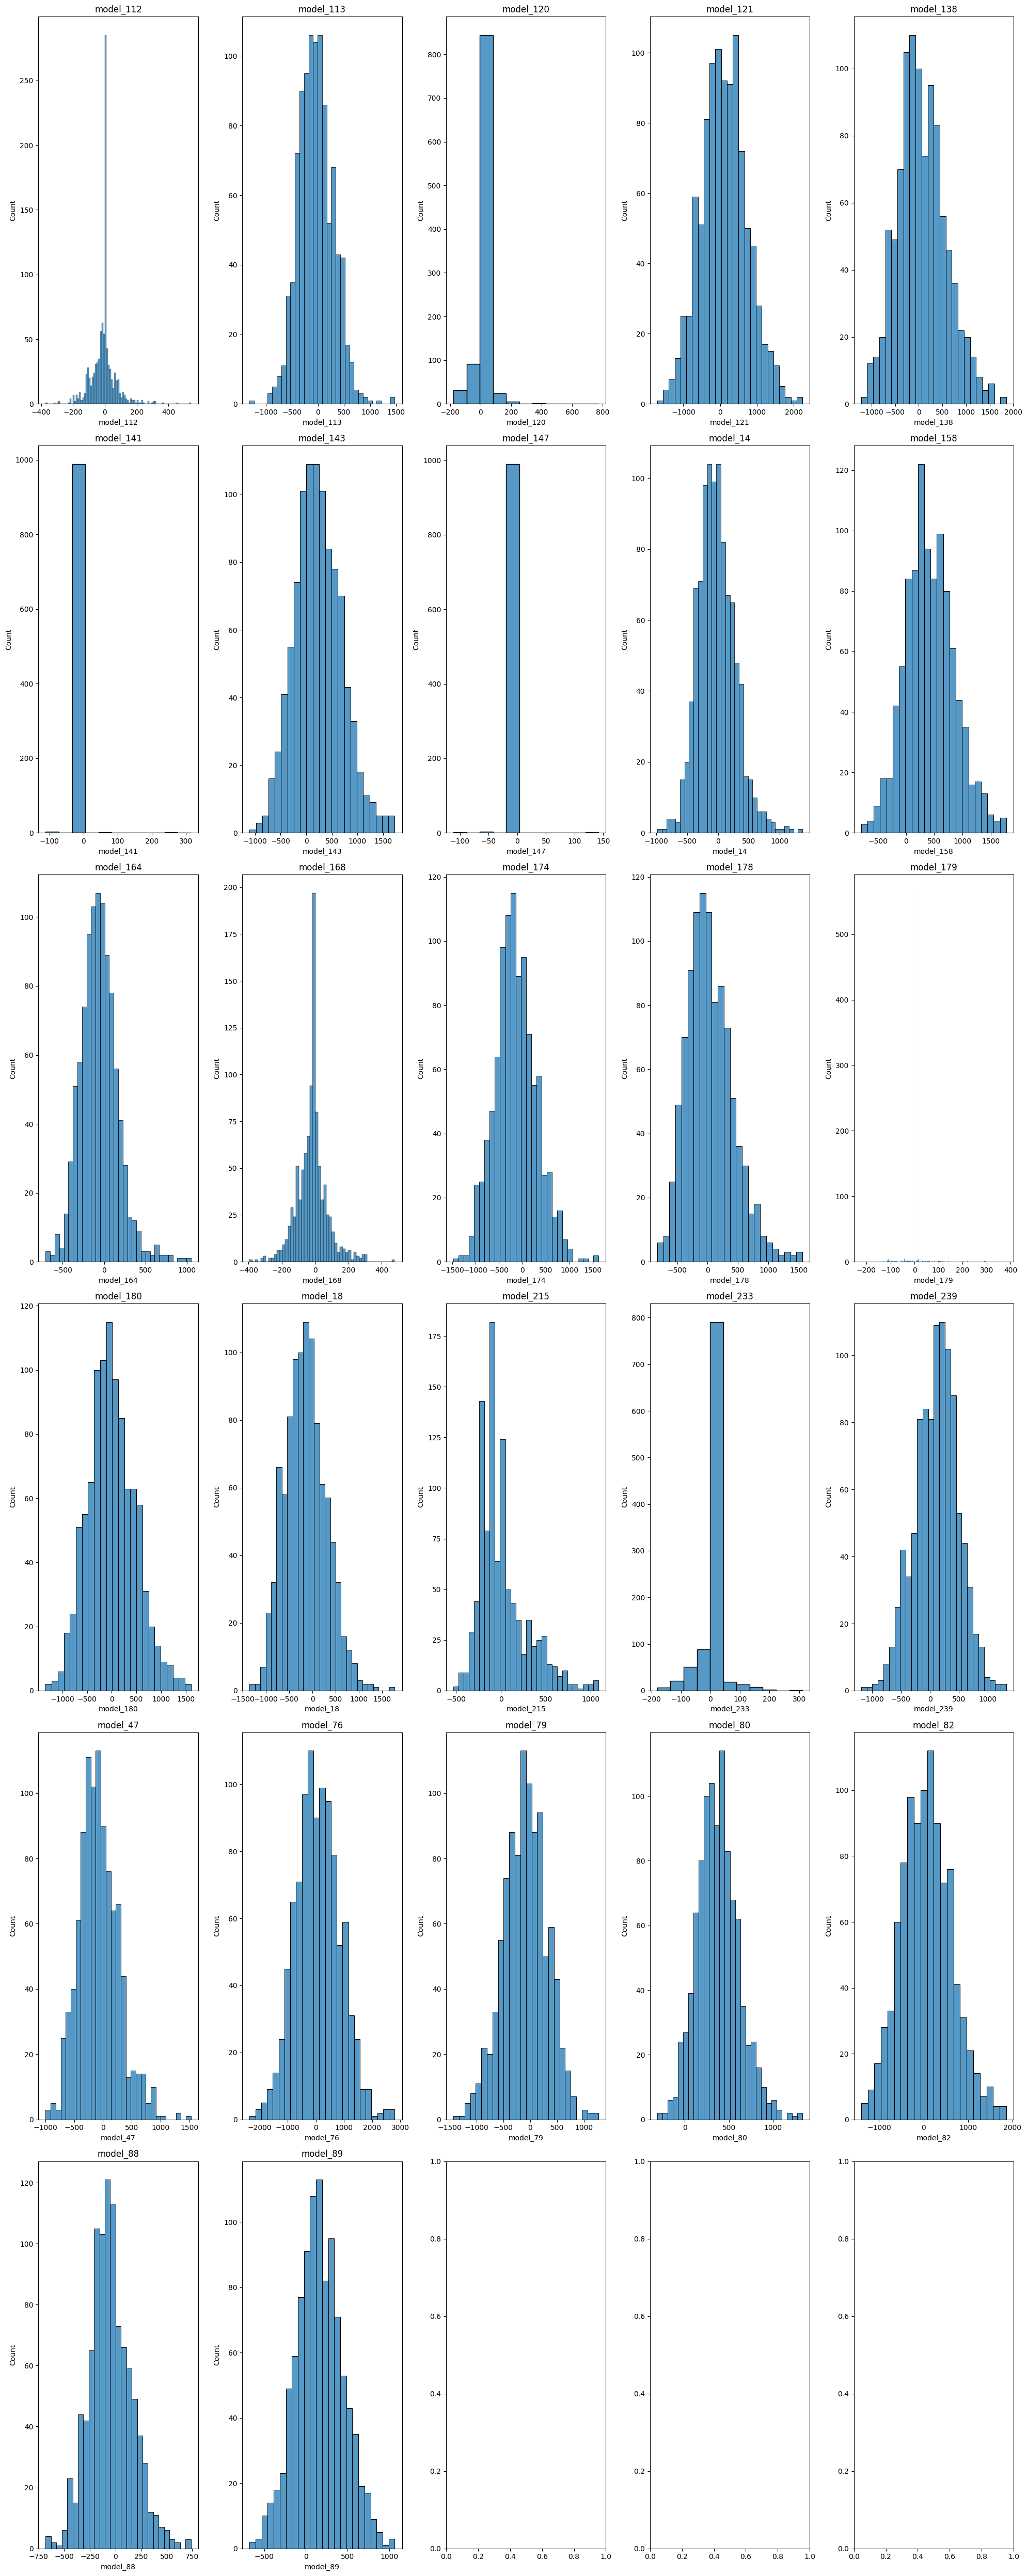

In [41]:
# Create a grid of subplots for every column in df where there are 7 rows and 7 columns that show the distribution of the data

# Create a grid of subplots
fig, axs = plt.subplots(nrows=int(np.ceil(len(df_nan_replaced.columns)/5)), ncols=5, figsize=(20, 50))

# Flatten the axs array
axs = axs.flatten()

# Iterate over the columns in df
for i, col in enumerate(df.columns):
    # Plot the distribution of the column
    sns.histplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(col)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [47]:
numbers = [158,80,89,138,121]
# 'model_9_2024-06-14.pkl'
models = [f'model_{num}_{max_date_1hr.date()}.pkl' for num in numbers]
orders_rendered = {}
num_episodes = 1
for num, model in tqdm(zip(numbers, models)):

    # model_ppo = PPO('MultiInputPolicy', train_env, verbose=0, ent_coef=m_ppo_ent_coef, learning_rate=m_ppo_lr, gamma=m_ppo_gamma)
    obs_tr, info_tr = train_env.reset(seed=seed)
    model_ppo = PPO.load(f'models_{max_date_1hr.date()}/{model}', train_env)
    # model_ppo.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))   

    rewards = []
    for episode in range(num_episodes):
        obs_test, info_test = env_validation_2.reset(seed=seed)
        # model_ppo = PPO.load(f'gym_mtsim_forked/gym_mtsim/data/model_0.pkl', train_env)
        done_test = False
        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)
            done_test = terminated_test or truncated_test
            
            total_reward += reward_test
            if done_test:
                break
        orders_rendered[f'{num}'] = env_validation_2.render()['orders']
        try:
            orders_made_in_episode_test = env_validation_2.render()['orders']
            # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
            order_len = len(orders_made_in_episode_test)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode_test, 0.001)
            rewards.append(total_profit)
        except Exception as e:
            print(f'There were not any orders produced by the model. Error = {e}')
            rewards.append(0)
            order_len = 0

5it [00:01,  3.05it/s]


In [48]:
for num in numbers:
    print(num)
    print(orders_rendered[f'{num}'].groupby('Type').count()['Volume'])

158
Type
Buy    11
Name: Volume, dtype: int64
80
Type
Sell    5
Name: Volume, dtype: int64
89
Type
Sell    20
Name: Volume, dtype: int64
138
Type
Buy     11
Sell    19
Name: Volume, dtype: int64
121
Type
Buy      9
Sell    28
Name: Volume, dtype: int64


In [46]:
# print(df_nan_replaced['model_17'].min(),
# df_nan_replaced['model_17'].max(),
# df_nan_replaced['model_17'].mean(),
# len(df_nan_replaced[df_nan_replaced['model_17'] > 0]),
# len(df_nan_replaced[df_nan_replaced['model_17'] < 0]))